In [1]:
try:
    from pathlib import Path
    import pandas as pd
    import matplotlib.pyplot as plt
    from lib.lib_utils import Utils
    import seaborn as sns
    from lib.lib_defect_analysis import Features
    from tqdm import tqdm
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
    import xgboost as xgb
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from tqdm import tqdm
    from matplotlib.ticker import MaxNLocator
    import cv2
    import json
    import pywt
    import xgboost as xgb
    import lightgbm as lgb
    from matplotlib.colors import LinearSegmentedColormap
    import shap
except Exception as e:
    print(f"Some module are missing: {e}\n")

/home/tom/Applications/miniconda3/envs/yolov10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = Path("/home/tom/git_workspace/tesi/GrapheNetDefectDetector/data_tesi_new")
yolo_model_path = Path("/home/tom/git_workspace/tesi/GrapheNetDefectDetector/best_model_yolov10n.pt")

xyz_files_path = data_path.joinpath("xyz_files")
images_path = data_path.joinpath("images")
crops_path = data_path.joinpath("crops")

plot_path = data_path.joinpath("plots")
pred_path = data_path.joinpath("predictions")

data_path.joinpath("models").mkdir(exist_ok=True,parents=True)

plot_path.mkdir(exist_ok=True, parents=True)
pred_path.mkdir(exist_ok=True, parents=True)
plt.style.use("seaborn-v0_8-paper")
colors = ["#F0741E", "#276CB3"]

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [colors[1], colors[0]])

In [4]:
# max_dim = [39.53476932, 34.27629786]
# Utils.from_xyz_to_png(xyz_files_path, images_path, max_dim=max_dim, multiplier=6)

# Utils.generate_yolo_crops(
#     images_path,
#     crops_path,
#     yolo_model_path,
#     binary_mask=True,
#     device="cpu",
#     confidence=0.75,
# )

In [3]:
def calculate_entropy(data: np.ndarray, bins: int = 256) -> float:
    data_flat = data.flatten()
    histogram, _ = np.histogram(data_flat, bins=bins, range=(0, bins), density=True)
    entropy = -np.sum(histogram * np.log2(histogram + 1e-10))
    return entropy


def clalc_shift_spect(img):
    f = np.fft.fft2(img)

    coeffs = pywt.wavedec2(img, "haar", level=2)
    return f, coeffs


def extract_frequency_features(
    image: Path | np.ndarray, wavelet: str = "db4", bins: int = 256
) -> dict:
    image = image.resolve()
    if isinstance(image, Path):
        img = cv2.imread(str(image), cv2.IMREAD_GRAYSCALE)
    else:
        img = image.copy()
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # f = np.fft.fft2(img)
    f, coeffs = clalc_shift_spect(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1e-10)

    mean_freq = np.mean(magnitude_spectrum)
    std_freq = np.std(magnitude_spectrum)
    max_freq = np.max(magnitude_spectrum)
    min_freq = np.min(magnitude_spectrum)
    median_freq = np.median(magnitude_spectrum)
    energy = np.sum(np.abs(fshift) ** 2)

    rows, cols = magnitude_spectrum.shape
    crow, ccol = rows // 2, cols // 2

    histogram, _ = np.histogram(
        magnitude_spectrum, bins=bins, range=(0, bins), density=True
    )
    entropy = -np.sum(histogram * np.log2(histogram + 1e-10))

    low_freq_energy = np.sum(magnitude_spectrum[:crow, :ccol])
    high_freq_energy = np.sum(magnitude_spectrum[crow:, ccol:])
    frequency_contrast = high_freq_energy - low_freq_energy

    # coeffs = pywt.wavedec2(img, wavelet, level=2)
    cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs

    wavelet_features = {
        "wavelet_energy_A2": np.sum(np.square(cA2)),
        "wavelet_energy_H2": np.sum(np.square(cH2)),
        "wavelet_energy_V2": np.sum(np.square(cV2)),
        "wavelet_energy_D2": np.sum(np.square(cD2)),
        "wavelet_std_A2": np.std(cA2),
        "wavelet_std_H2": np.std(cH2),
        "wavelet_std_V2": np.std(cV2),
        "wavelet_std_D2": np.std(cD2),
        "wavelet_energy_H1": np.sum(np.square(cH1)),
        "wavelet_energy_V1": np.sum(np.square(cV1)),
        "wavelet_energy_D1": np.sum(np.square(cD1)),
        "wavelet_std_H1": np.std(cH1),
        "wavelet_std_V1": np.std(cV1),
        "wavelet_std_D1": np.std(cD1),
        "wavelet_entropy_A2": calculate_entropy(cA2, bins),
        "wavelet_entropy_H2": calculate_entropy(cH2, bins),
        "wavelet_entropy_V2": calculate_entropy(cV2, bins),
        "wavelet_entropy_D2": calculate_entropy(cD2, bins),
        "wavelet_entropy_H1": calculate_entropy(cH1, bins),
        "wavelet_entropy_V1": calculate_entropy(cV1, bins),
        "wavelet_entropy_D1": calculate_entropy(cD1, bins),
    }

    frequency_features = {
        "mean_frequency": mean_freq,
        "std_frequency": std_freq,
        "max_frequency": max_freq,
        "min_frequency": min_freq,
        "median_frequency": median_freq,
        "energy": energy,
        "entropy": entropy,
        "low_frequency_energy": low_freq_energy,
        "high_frequency_energy": high_freq_energy,
        "frequency_contrast": frequency_contrast,
    }

    frequency_features.update(wavelet_features)

    return frequency_features

In [5]:
features_list = [
    "area",
    "perimeter",
    "circularity",
    "solidity",
    "compactness",
    "feret_diameter",
    "edge_density",
    "eccentricity",
    "number_of_edges",
    "GLCM_energy",
    "GLCM_correlation",
    "GLCM_homogeneity",
    #"GLCM_energy",
    "GLCM_contrast",
    "max_frequency",
    "energy",
    "entropy",
    "std_frequency",
    "min_frequency",
    "mean_frequency",
    "median_frequency",
    "low_frequency_energy",
    "high_frequency_energy",
    "frequency_contrast",
    "wavelet_energy_A2",
    "wavelet_energy_H2",
    "wavelet_energy_V2",
    "wavelet_energy_D2",
    "wavelet_std_A2",
    "wavelet_std_H2",
    "wavelet_std_V2",
    "wavelet_std_D2",
    "wavelet_energy_H1",
    "wavelet_energy_V1",
    "wavelet_energy_D1",
    "wavelet_std_H1",
    "wavelet_std_V1",
    "wavelet_std_D1",
    "wavelet_entropy_A2",
    "wavelet_entropy_H2",
    "wavelet_entropy_V2",
    "wavelet_entropy_D2",
    "wavelet_entropy_H1",
    "wavelet_entropy_V1",
    "wavelet_entropy_D1",
]


target_list = [
    "fermi_level_ev",
    "IP_ev",
    "EA_ev",
    "band_gap_ev",
    "energy_per_atom",
    "current",

]

target_list_names = {
    "fermi_level_ev":"Fermi Level",
    "IP_ev":"Ionization Potential",
    "EA_ev":"Electron Affinity",
    "band_gap_ev": "Band Gap",
    "energy_per_atom": "Energy per atom",
    "current":"Current",
}

target_labels = {
    "fermi_level_ev": ("Fermi Level [eV] - predicted", "Fermi Level[eV] - true"),
    "IP_ev": (
        "Ionization Potential [eV] - predicted",
        "Ionization Potential [eV] - true",
    ),
    "EA_ev": ("Electron Affinity [eV] - predicted", "Electron Affinity [eV] - true"),
    "band_gap_ev": ("Band Gap [eV] - predicted", "Band Gap [eV] - true"),
    "energy_per_atom": (
        "Energy per atom [eV] - predicted",
        "Energy per atom [eV] - true",
    ),
    "current": (
        "Current [μA] - predicted",
        "Current [μA] - true",
    ),
}

In [6]:
filepath = data_path.joinpath("features.csv").exists()

In [7]:
if not filepath:
    images = [
        f for f in crops_path.iterdir() if f.suffix.lower() in Features.IMAGE_EXTENSIONS
    ]

    features = {}

    for image in tqdm(images):
        if len(features) == 0:
            keys_list = list(features.keys())
            df = pd.DataFrame(columns=keys_list)
        else:
            features.clear()

        name = image.stem.split("_crop")[0]

        with open(str(xyz_files_path.joinpath(f"{name}.xyz")), "r") as file:
            first_line = file.readline()
        n_atoms = int(first_line.strip())

        features.update({"file_name": name})
        features.update({"n_atoms": n_atoms})

        shape_features = Features.extract_shape_features(image, grayscale=True)
        if shape_features is not None:
            features.update(shape_features)

        edge_features = Features.extract_edge_features(image, grayscale=True)
        if edge_features is not None:
            features.update(edge_features)

        texture_features = Features.extract_texture_features(image)
        if texture_features is not None:
            features.update(texture_features)

        # frequency_features = Features.extract_frequency_features(image)
        # if frequency_features is not None:
        #     features.update(frequency_features)

        new_row = pd.Series(features)
        df = pd.concat([df, new_row.to_frame().T], ignore_index=True)
        df["file_name"] = df["file_name"].str.replace("_opt", "", regex=False)
    grouped_df = (
        df.groupby("file_name")
        .agg(
            {
                "n_atoms": "first",
                "area": "sum",
                "num_pixels": "sum",
                "perimeter": "sum",
                "circularity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "solidity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "compactness": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "feret_diameter": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "eccentricity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "number_of_edges": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "edge_density": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_contrast": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_homogeneity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_energy": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_correlation": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
            }
        )
        .reset_index()
    )

    #
    original_df = pd.read_csv("/home/tom/git_workspace/tesi/GrapheNetDefectDetector/dataset_sorted.csv")

    energy_dict = original_df.set_index("file_name")["total_energy"].to_dict()
    fermi_dict = original_df.set_index("file_name")["Fermi_energy"].to_dict()
    ip_dict = original_df.set_index("file_name")["ionization_potential"].to_dict()
    ea_dict = original_df.set_index("file_name")["electron_affinity"].to_dict()
    band_gap_dict = original_df.set_index("file_name")["band_gap"].to_dict()
    current_dict = original_df.set_index("file_name")["current"].to_dict()
    formation_dict = original_df.set_index("file_name")["formation_energy"].to_dict()
    # flake_total_area_dict = original_df.set_index("file_name")[
    #     "flake_total_area"
    # ].to_dict()

    # Aggiunta della colonna total_energy al primo dataframe
    grouped_df["total_energy_eV"] = grouped_df["file_name"].map(energy_dict)
    grouped_df["fermi_level_ev"] = grouped_df["file_name"].map(fermi_dict)
    grouped_df["IP_ev"] = grouped_df["file_name"].map(ip_dict)
    grouped_df["EA_ev"] = grouped_df["file_name"].map(ea_dict)
    grouped_df["band_gap_ev"] = grouped_df["file_name"].map(band_gap_dict)
    # grouped_df["energy_per_atom"] = (
    #     grouped_df["total_energy_eV"] / grouped_df["n_atoms"]
    # )
    grouped_df["current"] = grouped_df["file_name"].map(current_dict)
    grouped_df["energy_per_atom"] = grouped_df["file_name"].map(formation_dict) / grouped_df["n_atoms"]

    #grouped_df["flake_total_area"] = grouped_df["file_name"].map(flake_total_area_dict)
    grouped_df = grouped_df.dropna()

    grouped_df.to_csv(data_path.joinpath("features.csv"), index=False)
else:
    grouped_df = pd.read_csv(data_path.joinpath("features.csv"))

In [8]:
frequency_dict = {}
for filename in tqdm(grouped_df["file_name"].to_list()):
    img = images_path.joinpath(f"{filename}_opt.png")
    dict_img = extract_frequency_features(img)
    frequency_dict[filename] = dict_img

  0%|          | 0/12513 [00:00<?, ?it/s]

100%|██████████| 12513/12513 [00:45<00:00, 274.35it/s]


Convert the current from Ampere of simulation to microampere


In [9]:
grouped_df["current"] = grouped_df["current"] * 1e6

In [10]:
frequency_df = pd.DataFrame.from_dict(frequency_dict, orient="index")
grouped_df = grouped_df.join(frequency_df, on="file_name")

Remove the tail of the distribution, current near to zero is synonym of bad graphene flake


In [11]:
indices_to_remove = grouped_df[
    (grouped_df["current"] >= grouped_df["current"].min())
    & (grouped_df["current"] <= 9e-02)
].index
print(indices_to_remove, len(indices_to_remove))
# Rimuovere le righe corrispondenti agli indici trovati
grouped_df = grouped_df.drop(indices_to_remove)

Index([188, 4464], dtype='int64') 2


In [12]:
if grouped_df.isna().any().any():
    print("Avviso: Il DataFrame contiene valori NaN.")
else:
    print("Il DataFrame non contiene valori NaN.")

Il DataFrame non contiene valori NaN.


In [13]:
df_filtrato = grouped_df#grouped_df[grouped_df["area"] / grouped_df["flake_total_area"] < 0.3]
# indices_to_remove = df_filtrato[
#     (df_filtrato["n_atoms"] >= 450)
#     # & (df_filtrato["dos"] <= df_filtrato.min() + 2 * 1e-07)
# ].index

# Rimuovere le righe corrispondenti agli indici trovati
# df_filtrato = df_filtrato.drop(indices_to_remove)
dist_path = plot_path.joinpath("distributions")
dist_path.mkdir(exist_ok=True, parents=True)
for feature in features_list:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)  # Aggiungi subplot

    sns.histplot(
        x=df_filtrato[feature],
        fill=True,
        linewidth=1,
        kde=False,
        stat="density",
        color=colors[1],
        ax=ax,
        bins=int(np.sqrt(len(df_filtrato[feature]))),
    )

    sns.kdeplot(x=df_filtrato[feature], linewidth=2, color=colors[0], ax=ax)

    ax.xaxis.set_major_locator(
        MaxNLocator(nbins=3)
    )  # Imposta massimo 3 ticks sull'asse x
    ax.yaxis.set_major_locator(
        MaxNLocator(nbins=3)
    )  # Imposta massimo 3 ticks sull'asse y
    ax.set_xlabel(feature, fontsize=20)
    ax.set_ylabel(f"{feature} Density", fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.tight_layout()
    plt.savefig(
        dist_path.joinpath(f"{feature}_distribution.png"), dpi=300, bbox_inches="tight"
    )
    plt.close(fig)

Plot the correlation matrix of all the features list


In [14]:
# correlation_matrix = grouped_df[features_list].corr()
# plt.figure(figsize=(25, 25))
# sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, vmin=-1, vmax=1)
# plt.title("Correlation Matrix of Features")
# plt.show()

XGBoost


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Lista delle feature
features_list = [
    "area", "perimeter", "circularity", "solidity", "compactness", "feret_diameter", "edge_density", "eccentricity",
    "number_of_edges", "GLCM_energy", "GLCM_correlation", "GLCM_homogeneity", "GLCM_contrast",
    "max_frequency", "energy", "entropy", "std_frequency", "min_frequency", "mean_frequency", "median_frequency",
    "low_frequency_energy", "high_frequency_energy", "frequency_contrast", "wavelet_energy_A2", "wavelet_energy_H2",
    "wavelet_energy_V2", "wavelet_energy_D2", "wavelet_std_A2", "wavelet_std_H2", "wavelet_std_V2", "wavelet_std_D2",
    "wavelet_energy_H1", "wavelet_energy_V1", "wavelet_energy_D1", "wavelet_std_H1", "wavelet_std_V1", "wavelet_std_D1",
    "wavelet_entropy_A2", "wavelet_entropy_H2", "wavelet_entropy_V2", "wavelet_entropy_D2", "wavelet_entropy_H1",
    "wavelet_entropy_V1", "wavelet_entropy_D1"
]

features_list_names = [
    "Area", "Perimeter", "Circularity", "Solidity", "Compactness", "Feret diameter", "Edge density", "Eccentricity",
    "Number of edges", "GLCM energy", "GLCM correlation", "GLCM homogeneity", "GLCM contrast",
    "Max frequency", "Fourier Energy", "Fourier Entropy", "STD frequency", "Min frequency", "Mean frequency", "Median frequency",
    "Low frequency energy", "High frequency energy", "Frequency contrast", "Wavelet energy A2", "Wavelet energy H2",
    "Wavelet energy V2", "Wavelet energy D2", "Wavelet STD A2", "Wavelet STD H2", "Wavelet STD V2", "Wavelet STD D2",
    "Wavelet energy H1", "Wavelet energy V1", "Wavelet energy D1", "Wavelet STD H1", "Wavelet STD V1", "Wavelet STD D1",
    "Wavelet entropy A2", "Wavelet entropy H2", "Wavelet entropy V2", "Wavelet entropy D2", "Wavelet entropy H1",
    "Wavelet entropy V1", "Wavelet entropy D1"
]

# Numero di colonne per i plot
# cols = 4
# # Calcola il numero di righe necessarie
# rows = (len(features_list) + cols - 1) // cols

# plt.figure(figsize=(20, 5 * rows))

# # Genera uno scatter plot per ogni feature rispetto al target
# for i, feature in enumerate(features_list):
#     plt.subplot(rows, cols, i + 1)
#     plt.scatter(grouped_df[feature], grouped_df["band_gap_ev"])
#     plt.xlabel(feature)
#     plt.ylabel('bandgap')
#     plt.title(f'{feature} vs bandgap')

# plt.tight_layout()
# plt.show()


In [ ]:
summary_path = plot_path.joinpath("shap")
summary_path.mkdir(exist_ok=True, parents=True)
params = {
    "n_estimators": 770,
    "learning_rate": 0.05121628616721255,
    "max_depth": 15,
    "gamma": 1.0412841060924395e-05,
    "min_child_weight": 6.3754851529818195,
    "colsample_bytree": 0.6501726650749249,
    "max_leaves": 148,
    "subsample": 0.913755592717715,
    "reg_alpha": 0.5268057823898837,
    "reg_lambda": 1.9309701023337404,
    "eval_metric": ["rmse", "mae"],
    # L2 regularization
}
model = xgb.XGBRegressor(**params)


# Scaled targets
scaled_targets = ["current"]

# Copy the dataframe
grouped_df = df_filtrato.copy()

# Features and normalization
X = grouped_df[features_list].values
# scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler = RobustScaler()
X_norm = scaler.fit_transform(X)

# Dictionaries to store feature importance and scores
feature_importance_dict = {}
feature_importance_dict_test = {}

# Lists to store scores
scores = []
scores_train = []

# Track learning curves
learning_curves = {}

for target in tqdm(target_list):
    target_scores = []
    file_names = grouped_df["file_name"]
    y = grouped_df[target].values.flatten()
    scaler2 = RobustScaler()
    y_norm = np.squeeze(scaler2.fit_transform(y.reshape(-1, 1)))

    if target in scaled_targets:
        combined = list(zip(X_norm, y_norm, file_names))
    else:
        combined = list(zip(X_norm, y, file_names))

    train, test = train_test_split(combined, test_size=0.2, random_state=3333)

    # Separate X, y, and file_names for train and test
    X_train, y_train, file_names_train = zip(*train)
    X_test, y_test, file_names_test = zip(*test)

    # Convert to numpy arrays for use with scikit-learn
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.round(np.array(y_train), 4)
    y_test = np.round(np.array(y_test), 4)

    # Track the learning curve
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train.ravel(), eval_set=eval_set, verbose=False)

    # Extract learning curve data
    eval_results = model.evals_result()
    train_rmse = np.square(eval_results["validation_0"]["rmse"])
    test_rmse = np.square(eval_results["validation_1"]["rmse"])
    train_mae = eval_results["validation_0"]["mae"]
    test_mae = eval_results["validation_1"]["mae"]
    learning_curves[target] = {
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_mae": train_mae,
        "test_mae": test_mae,
    }

    # Save learning curves to CSV
    learning_curve_df = pd.DataFrame(
        {
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "train_mae": train_mae,
            "test_mae": test_mae,
        }
    )
    learning_curve_df.to_csv(
        pred_path.joinpath(f"{target}_learning_curve.csv"), index=False
    )

    # Feature importance
    feature_importance = model.feature_importances_
    feature_importance_dict[f"{target}_importance"] = feature_importance

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    if target in scaled_targets:
        y_test = np.round(scaler2.inverse_transform(y_test.reshape(-1, 1)).flatten(), 4)
        y_pred = np.round(scaler2.inverse_transform(y_pred.reshape(-1, 1)).flatten(), 4)
        y_train = np.round(
            scaler2.inverse_transform(y_train.reshape(-1, 1)).flatten(), 4
        )
        y_pred_train = np.round(
            scaler2.inverse_transform(y_pred_train.reshape(-1, 1)).flatten(), 4
        )

    # Round predicted values to the fourth decimal place
    y_pred = np.round(y_pred, 4)
    y_pred_train = np.round(y_pred_train, 4)

    residual_error = y_test - y_pred
    results_df = pd.DataFrame(
        {
            f"{target}_predicted": y_pred,
            f"{target}_real": y_test,
            f"{target}_residual": residual_error,
        }
    )
    results_df_train = pd.DataFrame(
        {
            f"{target}_predicted": y_pred_train,
            f"{target}_real": y_train,
        }
    )

    # Save the DataFrame to a CSV
    results_df.to_csv(pred_path.joinpath(f"{target}_predictions.csv"), index=False)
    results_df_train.to_csv(
        pred_path.joinpath(f"{target}_predictions_train.csv"), index=False
    )

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    scores.append([mse, mae, r2])
    scores_train.append([mse_train, mae_train, r2_train])
    #SHAP explanation
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # Plot SHAP summary
    plt.figure(figsize=(7, 7))
    shap.summary_plot(
        shap_values, X_test, feature_names=features_list, show=False, cmap=custom_cmap
    )
    plt.xlabel(f'SHAP value (impact on target: {target_list_names[target]})')
    plt.savefig(
        summary_path.joinpath(f"{target}_shap_summary.png"), dpi=300, bbox_inches="tight"
    )

    plt.close()
    
    plt.figure(figsize=(7, 7))
    shap.summary_plot(
        shap_values, X_test, feature_names=features_list_names, show=False, cmap=custom_cmap
    )
    plt.xlabel(f'SHAP value (impact on target: {target_list_names[target]})')
    plt.savefig(
        summary_path.joinpath("fixed",f"{target}_shap_summary.png"), dpi=300, bbox_inches="tight"
    )

    plt.close()

    model.save_model(data_path.joinpath(f"models/{target}_best_model_xgb.json"))
mean_scores = np.mean(scores, axis=0)
mean_scores_train = np.mean(scores_train, axis=0)

print("Mean Test Scores (MSE, MAE, R2):", mean_scores)
print("Mean Train Scores (MSE, MAE, R2):", mean_scores_train)
# Plotting the learning curves

importance_path = plot_path.joinpath("importance")
importance_path.mkdir(exist_ok=True, parents=True)
np.savez(str(importance_path.joinpath("xgb_importance.npz")), **feature_importance_dict)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [10:36<00:00, 106.14s/it]00]        

Mean Test Scores (MSE, MAE, R2): [   0.042943    0.050949     0.95215]
Mean Train Scores (MSE, MAE, R2): [  0.0021923    0.013574      0.9879]


TypeError: Object of type ndarray is not JSON serializable

In [20]:
feature_importance_dict

{'fermi_level_ev_importance': array([   0.026101,    0.029375,   0.0025504,   0.0028837,   0.0027099,   0.0042368,    0.011582,   0.0022182,   0.0030782,   0.0048312,   0.0017686,   0.0029731,   0.0030624,     0.51727,     0.14583,   0.0012977,   0.0013315,   0.0006478,   0.0021379,   0.0043769,   0.0024216,    0.004253,   0.0013036,    0.049873,
           0.001564,    0.021589,   0.0014668,   0.0018427,   0.0017923,    0.018409,   0.0015603,   0.0017457,   0.0072327,   0.0017154,   0.0018469,   0.0074187,   0.0018414,   0.0021991,   0.0016459,   0.0018424,   0.0015721,     0.09197,   0.0014842,   0.0011472], dtype=float32),
 'IP_ev_importance': array([   0.043747,    0.026697,   0.0045904,   0.0044137,   0.0055127,   0.0047055,   0.0071588,   0.0033286,   0.0053581,   0.0070387,   0.0056063,   0.0053882,   0.0046644,     0.52371,    0.085495,   0.0023695,   0.0020654,   0.0010729,   0.0042108,   0.0045368,   0.0049679,   0.0046777,   0.0028763,    0.086209,
          0.0027622,   0.0

In [21]:
import pandas as pd
import matplotlib.pyplot as plt


# Numero di colonne per i plot
# cols = 4
# # Calcola il numero di righe necessarie
# rows = (len(feature_importance_dict["current_importance"]) + cols - 1) // cols

# plt.figure(figsize=(20, 5 * rows))

# # Genera uno scatter plot per ogni feature rispetto al target
# for i, feature in enumerate(features_list):
#     plt.subplot(rows, cols, i + 1)
#     plt.scatter(grouped_df[feature], grouped_df["current"])
#     plt.xlabel(feature)
#     plt.ylabel('current')
#     plt.title(f'{feature} vs current')

# plt.tight_layout()
# plt.show()


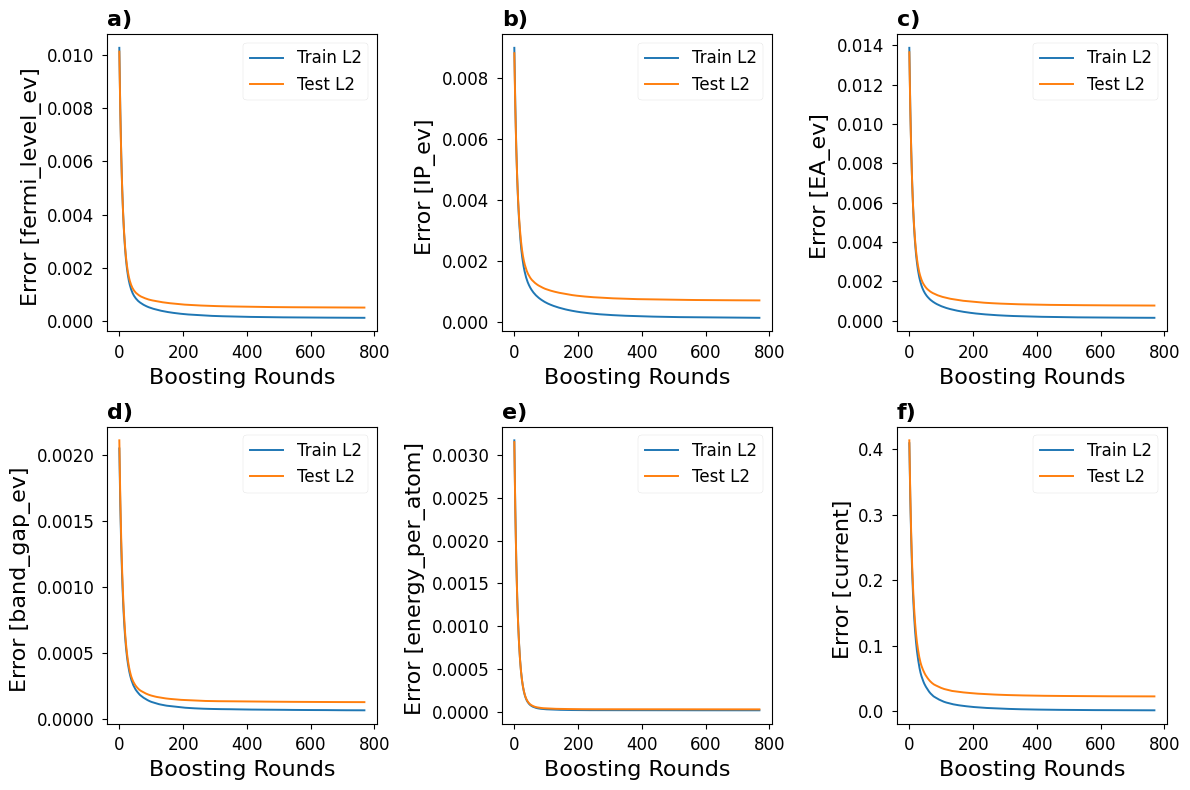

In [22]:
learn_path = plot_path.joinpath("learning_curves")
learn_path.mkdir(exist_ok=True, parents=True)

num_cols = 3
num_targets = len(target_list)
num_rows = (num_targets + num_cols - 1) // num_cols 

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

for idx, target in enumerate(target_list):
    learning_curve_df = pd.read_csv(pred_path.joinpath(f"{target}_learning_curve.csv"))
    row = idx // num_cols
    col = idx % num_cols

    ax = axs[row, col] if num_rows > 1 else axs[col]
    ax.plot(learning_curve_df["train_rmse"], label="Train L2")
    ax.plot(learning_curve_df["test_rmse"], label="Test L2")

    ax.set_xlabel("Boosting Rounds", fontsize=16)
    ax.set_ylabel(f"Error [{target}] ", fontsize=16)
    ax.legend(fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)  
    ax.tick_params(axis='both', which='minor', labelsize=10)
    letter = chr(97 + idx)  # 97 è il codice ASCII per 'a'

    ax.set_title(f"{letter})", loc='left', fontsize=16, fontweight='bold')

# Rimuovere eventuali subplot vuoti
for idx in range(num_targets, num_rows * num_cols):
    fig.delaxes(axs.flat[idx])

# Salvare la figura
plt.tight_layout()
plt.savefig(learn_path.joinpath("learning_curve_subplot_rmse.png"))
plt.show()


LightGBM


In [24]:
params = {
    "n_estimators": 770,
    "learning_rate": 0.05121628616721255,
    "max_depth": 15,
    "min_child_weight": 6.3754851529818195,
    "colsample_bytree": 0.6501726650749249,
    "num_leaves": 148,
    "subsample": 0.913755592717715,
    "reg_alpha": 0.5268057823898837,
    "reg_lambda": 1.9309701023337404,
    "objective": "regression",
}

model = lgb.LGBMRegressor(**params)

scaled_targets = ["current"]
grouped_df = df_filtrato.copy()
X = grouped_df[features_list].values
# scaler = MinMaxScaler()
scaler = RobustScaler()

X_norm = scaler.fit_transform(X)
feature_importance_dict_gbm = {}
learning_curves_gbm = {}

scores_gbm = []
scores_train_gbm = []
for target in tqdm(target_list):
    target_scores = []
    file_names = grouped_df["file_name"]
    y = grouped_df[target].values.flatten()
    

    if target in scaled_targets:
        scaler2 = RobustScaler()
        y_norm = np.squeeze(scaler2.fit_transform(y.reshape(-1, 1)))
        combined = list(zip(X_norm, y_norm, file_names))
    else:
        combined = list(zip(X_norm, y, file_names))

    train, test = train_test_split(combined, test_size=0.2, random_state=3333)

    # Separare X, y e file_names per train e test
    X_train, y_train, file_names_train = zip(*train)
    X_test, y_test, file_names_test = zip(*test)

    # Convertire in array numpy per l'utilizzo con scikit-learn
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    model.fit(X_train, y_train.ravel(), eval_set=[(X_train, y_train), (X_test, y_test)])
    feature_importance = model.feature_importances_

    eval_results = model.evals_result_
    train_rmse = eval_results["valid_0"]["l2"]
    test_rmse = eval_results["valid_1"]["l2"]

    learning_curves_gbm[target] = {
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
    }

    # Save learning curves to CSV
    learning_curve_df = pd.DataFrame(
        {
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
        }
    )
    learning_curve_df.to_csv(
        pred_path.joinpath(f"gbm_{target}_learning_curve.csv"), index=False
    )

    feature_importance_dict_gbm[f"{target}_importance"] = feature_importance

    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    if target in scaled_targets:
        y_train = scaler2.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_test = scaler2.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_train = scaler2.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
        y_pred = scaler2.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    explainer_gbm = shap.Explainer(model, X_train,output_names=f"{target}")
    shap_values_gbm = explainer_gbm(X_test,check_additivity=False)
    # Plot SHAP summary
    plt.figure(figsize=(7, 7))
    shap.summary_plot(
        shap_values_gbm, X_test, feature_names=features_list, show=False, cmap=custom_cmap, 
    )
    plt.xlabel(f'SHAP value (impact on target: {target_list_names[target]})')
    plt.savefig(
        summary_path.joinpath(f"gbm_{target}_shap_summary.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.close()
    plt.figure(figsize=(7, 7))
    shap.summary_plot(
        shap_values_gbm, X_test, feature_names=features_list_names, show=False, cmap=custom_cmap, 
    )
    plt.xlabel(f'SHAP value (impact on target: {target_list_names[target]})')
    plt.savefig(
        summary_path.joinpath("fixed",f"gbm_{target}_shap_summary.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.close()
    scores_gbm.append([mse, mae, r2])
    scores_train_gbm.append([mse_train, mae_train, r2_train])

    results_df = pd.DataFrame(
        {
            f"{target}_predicted": y_pred,
            f"{target}_real": y_test,
            f"{target}_residual": y_test - y_pred,
        }
    )
    results_df.to_csv(
        pred_path.joinpath(f"{target}_predictions_lightgbm.csv"), index=False
    )

    results_df_train = pd.DataFrame(
        {
            f"{target}_predicted": y_pred_train,
            f"{target}_real": y_train,
        }
    )
    results_df_train.to_csv(
        pred_path.joinpath(f"{target}_predictions_train_lightgbm.csv"), index=False
    )

# Calcolare le medie di tutte le metriche
mean_scores = np.mean(scores, axis=0)
mean_scores_train = np.mean(scores_train, axis=0)

print("Mean Test Scores (MSE, MAE, R2):", mean_scores)
print("Mean Train Scores (MSE, MAE, R2):", mean_scores_train)

importance_path = plot_path.joinpath("importance")
importance_path.mkdir(exist_ok=True, parents=True)
np.savez(str(importance_path.joinpath("gbm_importance.npz")), **feature_importance_dict_gbm)

  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 10008, number of used features: 44
[LightGBM] [Info] Start training from score -4.997890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

 17%|█▋        | 1/6 [01:21<06:48, 81.76s/it]:00]        

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 10008, number of used features: 44
[LightGBM] [Info] Start training from score 5.087170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

 33%|███▎      | 2/6 [02:45<05:31, 82.96s/it]:01]        

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 10008, number of used features: 44
[LightGBM] [Info] Start training from score 4.945249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

 50%|█████     | 3/6 [04:15<04:18, 86.13s/it]:00]        

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 10008, number of used features: 44
[LightGBM] [Info] Start training from score 0.141921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

 67%|██████▋   | 4/6 [04:59<02:19, 69.69s/it]:00]        

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 10008, number of used features: 44
[LightGBM] [Info] Start training from score -9.154984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

 83%|████████▎ | 5/6 [05:29<00:55, 55.24s/it]:00]        

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 10008, number of used features: 44
[LightGBM] [Info] Start training from score -0.002046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

100%|██████████| 6/6 [08:12<00:00, 82.02s/it]:00]        

Mean Test Scores (MSE, MAE, R2): [   0.042943    0.050949     0.95215]
Mean Train Scores (MSE, MAE, R2): [  0.0021923    0.013574      0.9879]


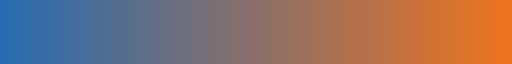

In [25]:
custom_cmap

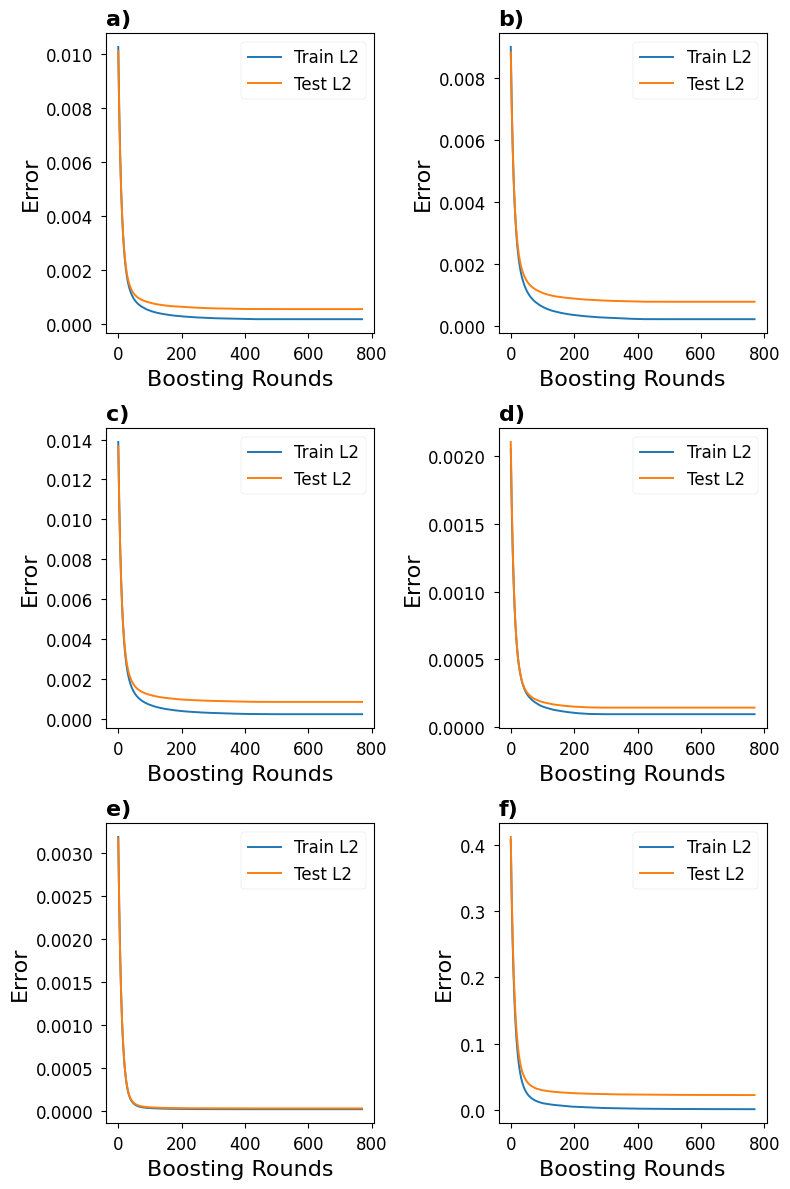

In [26]:
num_cols = 2

num_targets = len(target_list)
num_rows = (num_targets + num_cols - 1) // num_cols  # Arrotondare verso l'alto

# Creare i subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 4 * num_rows))

# Iterare sui target e sugli assi
for idx, target in enumerate(target_list):
    learning_curve_df = pd.read_csv(pred_path.joinpath(f"gbm_{target}_learning_curve.csv"))
    row = idx // num_cols
    col = idx % num_cols

    ax = axs[row, col] if num_rows > 1 else axs[col]
    ax.plot(learning_curve_df["train_rmse"], label="Train L2")
    ax.plot(learning_curve_df["test_rmse"], label="Test L2")

    ax.set_xlabel("Boosting Rounds", fontsize=16)
    ax.set_ylabel("Error", fontsize=16)
    ax.legend(fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)  # Ingrandisce i tick principali
    ax.tick_params(axis='both', which='minor', labelsize=10)
    letter = chr(97 + idx)  # 97 è il codice ASCII per 'a'

    ax.set_title(f"{letter})", loc='left', fontsize=16, fontweight='bold')

# Rimuovere eventuali subplot vuoti
for idx in range(num_targets, num_rows * num_cols):
    fig.delaxes(axs.flat[idx])

# Salvare la figura
plt.tight_layout()
plt.savefig(learn_path.joinpath("gbm_learning_curve_subplot_rmse.png"))
plt.show()


In [27]:
scores_array = np.array(scores)
scores_array_train = np.array(scores_train)

# plt.figure(figsize=(8, 8))
# plt.scatter(target_list, scores_array[:, 0])
# plt.scatter(target_list, scores_array_train[:, 0], marker="^")
# plt.ylabel("mean sqaured error")
# plt.figure(figsize=(8, 8))
# plt.scatter(target_list, scores_array[:, 1])
# plt.scatter(target_list, scores_array_train[:, 1], marker="^")

# plt.ylabel("mean absolute error")
# plt.figure(figsize=(8, 8))
# plt.scatter(target_list, scores_array[:, 2])
# plt.scatter(target_list, scores_array_train[:, 2], marker="^")
# plt.ylabel("R2 score")

In [28]:
scores_array

array([[ 0.00050625,    0.014494,     0.95414],
       [ 0.00070999,    0.016472,     0.92556],
       [ 0.00076768,    0.017031,      0.9482],
       [ 0.00012949,   0.0077974,     0.94326],
       [ 2.8254e-05,   0.0031754,     0.99186],
       [    0.25552,     0.24672,     0.94991]])

In [29]:
scores_array_gmb = np.array(scores_gbm)
scores_array_train_gbm = np.array(scores_train_gbm)
# plt.figure(figsize=(8, 8))
# plt.scatter(target_list, scores_array_gmb[:, 0])
# plt.scatter(target_list, scores_array_train_gbm[:, 0], marker="^")
# plt.ylabel("mean sqaured error")
# plt.figure(figsize=(8, 8))
# plt.scatter(target_list, scores_array_gmb[:, 1])
# plt.scatter(target_list, scores_array_train_gbm[:, 1], marker="^")

# plt.ylabel("mean absolute error")
# plt.figure(figsize=(8, 8))
# plt.scatter(target_list, scores_array_gmb[:, 2])
# plt.scatter(target_list, scores_array_train_gbm[:, 2], marker="^")
# plt.ylabel("R2 score")
scores_array_gmb

array([[ 0.00055927,    0.015751,     0.94933],
       [ 0.00077758,    0.017855,     0.91847],
       [ 0.00084376,    0.018564,     0.94306],
       [ 0.00014458,   0.0085682,     0.93665],
       [ 2.8959e-05,   0.0033844,     0.99166],
       [    0.25734,     0.24836,     0.94955]])

Plot on the test set prediction vs real


XGBoost


<Figure size 1000x1000 with 0 Axes>

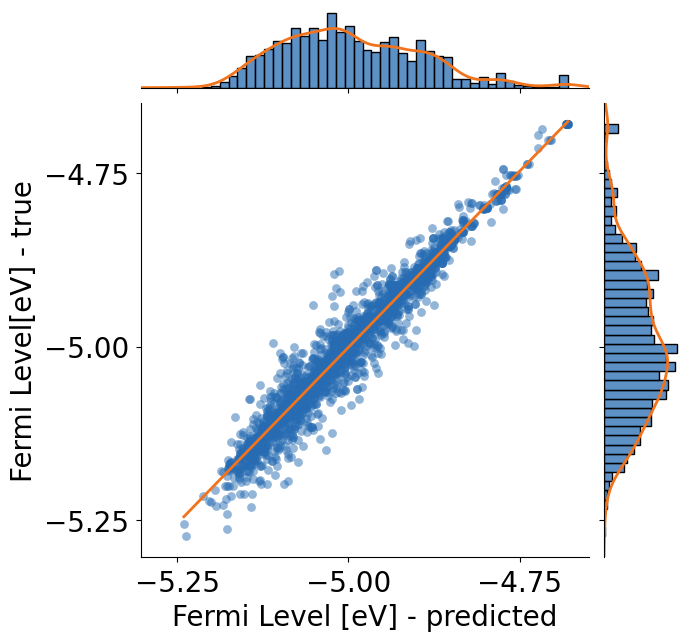

<Figure size 1000x1000 with 0 Axes>

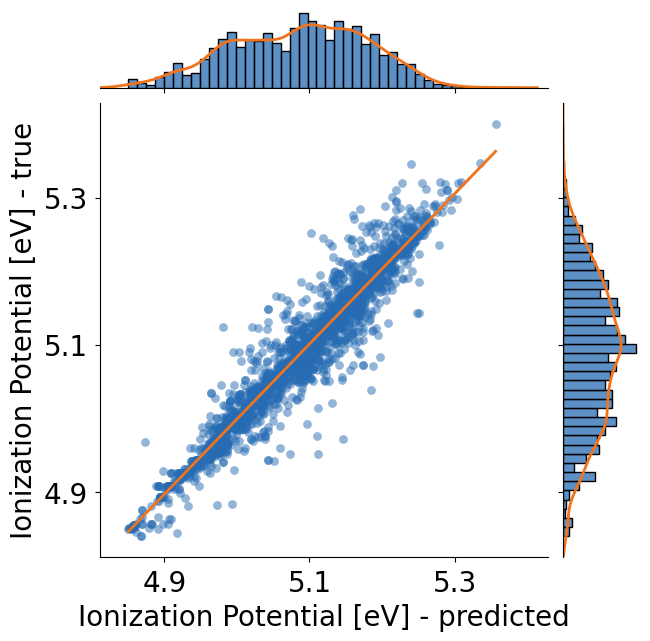

<Figure size 1000x1000 with 0 Axes>

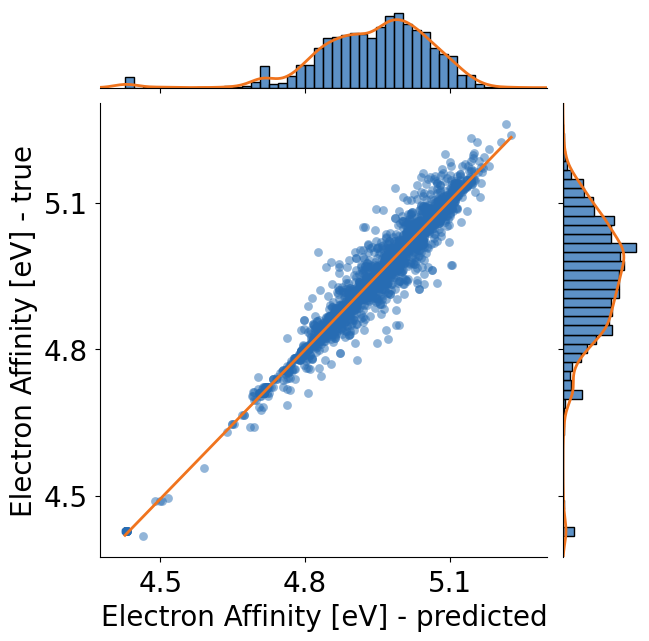

<Figure size 1000x1000 with 0 Axes>

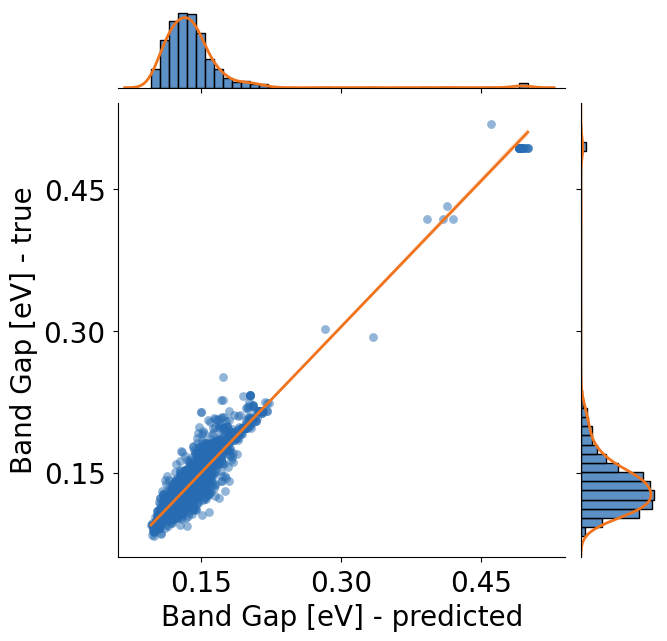

<Figure size 1000x1000 with 0 Axes>

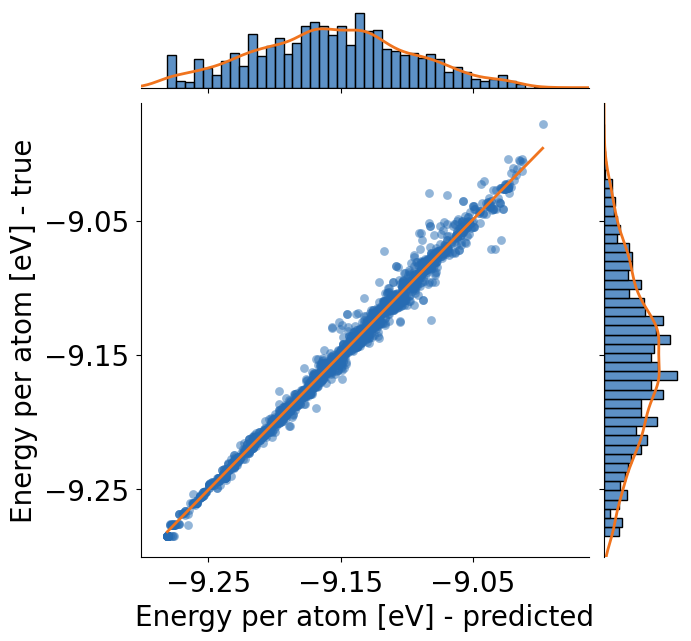

<Figure size 1000x1000 with 0 Axes>

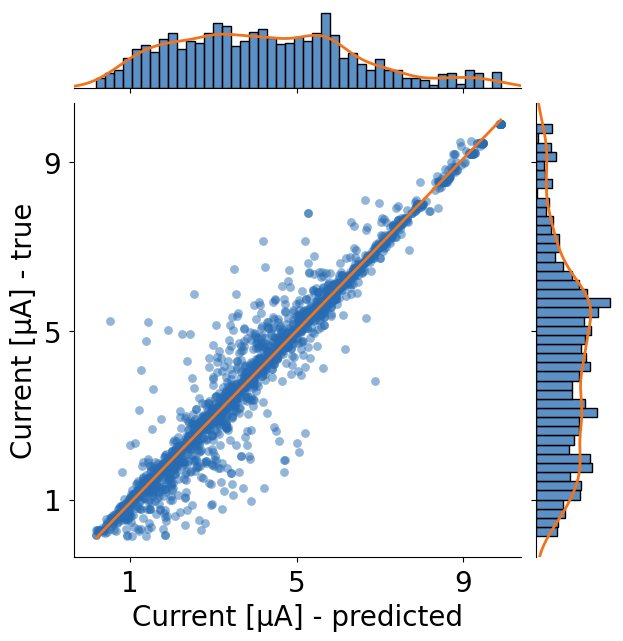

In [30]:
fit_path = plot_path.joinpath("fit")
fit_path.mkdir(exist_ok=True, parents=True)
ionisation_potential_ticks = [5.1,4.8,4.5]

ticks_dict = {
    "fermi_level_ev":[-5.25,-5.0,-4.75],
    "IP_ev":[5.3,5.1,4.9],
    "EA_ev":[5.1,4.8,4.5],
    "band_gap_ev":[0.15,0.3,0.45],
    "energy_per_atom":[-9.05,-9.15,-9.25],
    "current":[1,5,9],
}

for target in target_list:
    df = pd.read_csv(pred_path.joinpath(f"{target}_predictions.csv"), header=0)

    MAX = np.max(
        [df[f"{target}_predicted"].to_numpy(), df[f"{target}_real"].to_numpy()]
    )
    MIN = np.min(
        [df[f"{target}_predicted"].to_numpy(), df[f"{target}_real"].to_numpy()]
    )

    offset = 0.05 * np.abs(MAX - MIN)
    bound = [MIN - offset, MAX + offset]
    
    bins_thr=50

    fig = plt.figure(figsize=(10, 10))

    g = sns.JointGrid()
    x, y = df[f"{target}_predicted"], df[f"{target}_real"]
    sns.regplot(
        x=f"{target}_predicted",
        y=f"{target}_real",
        data=df,
        ax=g.ax_joint,
        scatter_kws={"s": 40, "alpha": 0.5, "color": colors[1]},
        line_kws={"linewidth": 2, "alpha": 1, "color": colors[0]},
    )
    sns.histplot(
        x=x,
        fill=True,
        linewidth=1,
        kde=False,
        ax=g.ax_marg_x,
        stat="density",
        color=colors[1],
        binwidth=abs(bound[0]-bound[1])/bins_thr
    )
    sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color=colors[0])
    sns.histplot(
        y=y,
        fill=True,
        linewidth=1,
        kde=False,
        ax=g.ax_marg_y,
        stat="density",
        color=colors[1],
        binwidth=abs(bound[0]-bound[1])/bins_thr
    )
    sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color=colors[0])
    g.ax_joint.set_xlim(bound)
    g.ax_joint.set_ylim(bound)
    g.ax_joint.tick_params(axis="both", which="major", labelsize=20)
    # if target=='EA_ev':
    #     g.ax_joint.set_xticks(ionisation_potential_ticks)
    #     g.ax_joint.set_yticks(ionisation_potential_ticks)
    # else:
    #     g.ax_joint.xaxis.set_major_locator(
    #         MaxNLocator(nbins=3, min_n_ticks=3)
    #     )  # Auto tick locator
    #     g.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=3, min_n_ticks=3))  #  #
        
    g.ax_joint.set_xticks(ticks_dict[target])
    g.ax_joint.set_yticks(ticks_dict[target])
    g.set_axis_labels(
        target_labels[f"{target}"][0], target_labels[f"{target}"][1], fontsize=20
    )

    plt.savefig(fit_path.joinpath(f"{target}_fit.png"), dpi=300, bbox_inches="tight")

LightGBM


<Figure size 1000x1000 with 0 Axes>

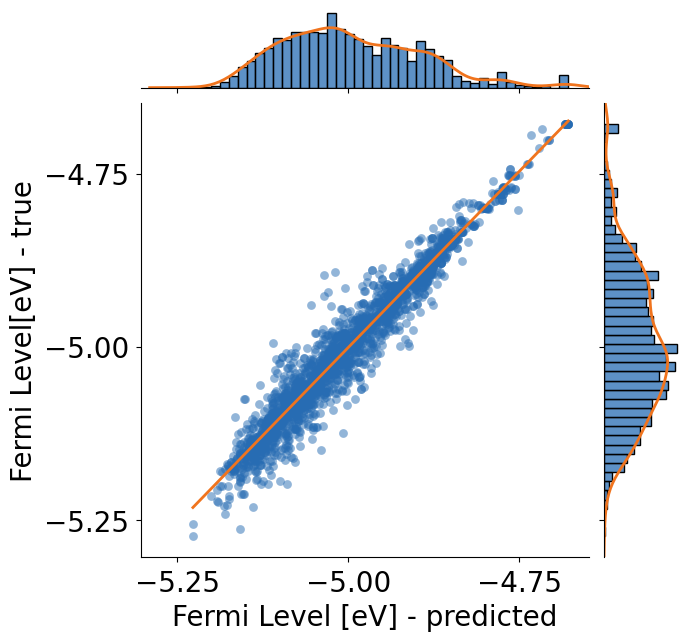

<Figure size 1000x1000 with 0 Axes>

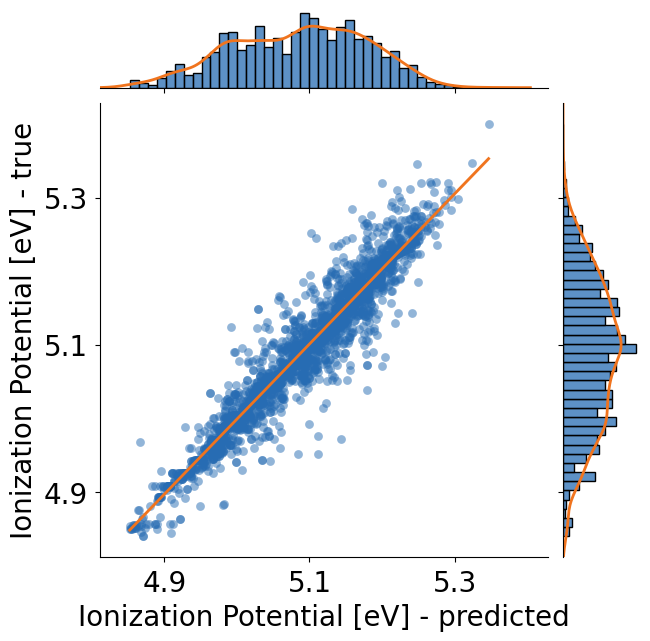

<Figure size 1000x1000 with 0 Axes>

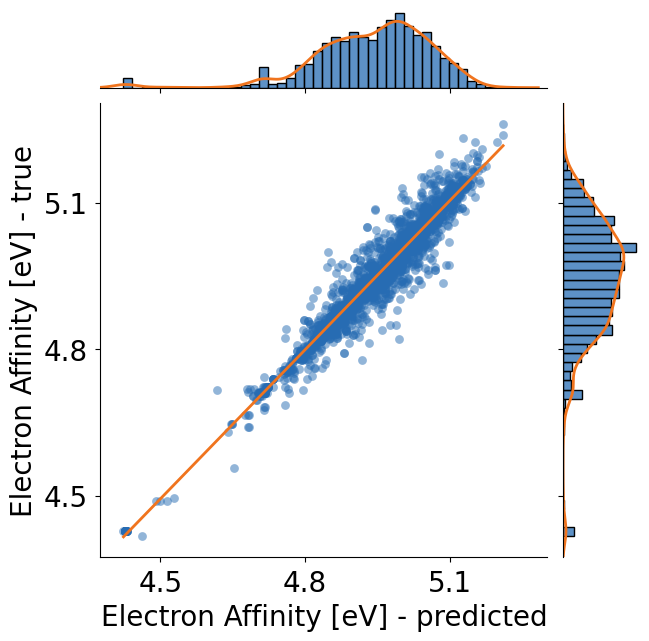

<Figure size 1000x1000 with 0 Axes>

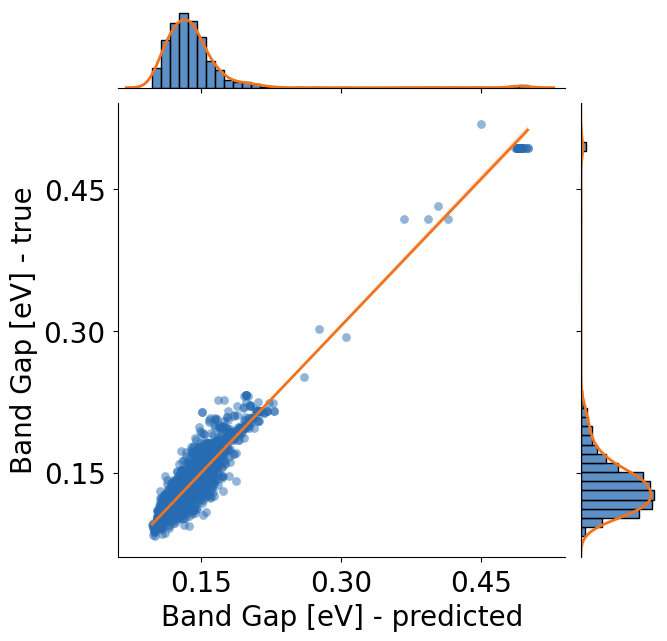

<Figure size 1000x1000 with 0 Axes>

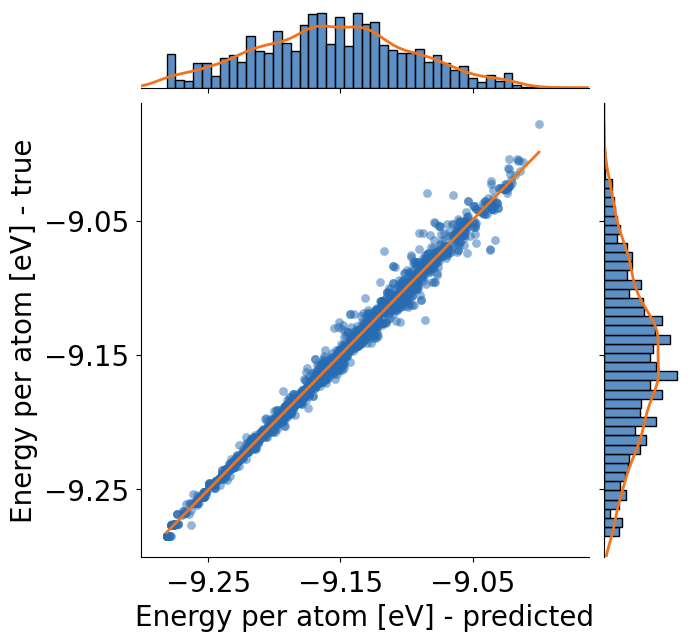

<Figure size 1000x1000 with 0 Axes>

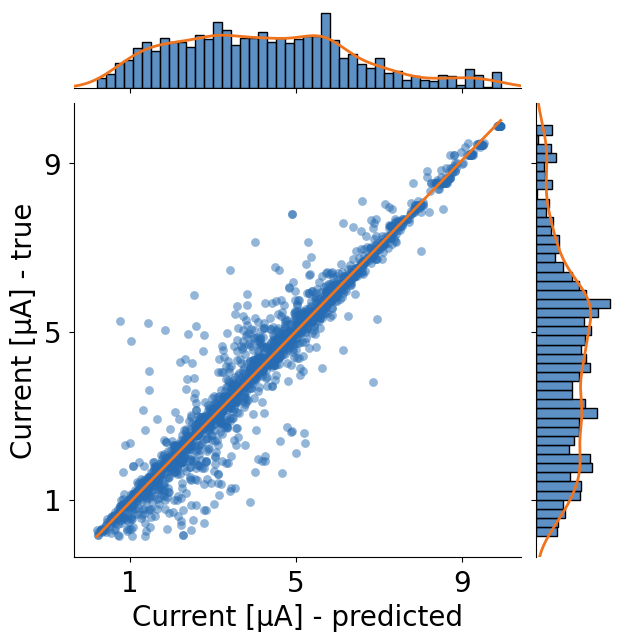

In [31]:
for target in target_list:
    df = pd.read_csv(pred_path.joinpath(f"{target}_predictions_lightgbm.csv"), header=0)

    MAX = np.max(
        [df[f"{target}_predicted"].to_numpy(), df[f"{target}_real"].to_numpy()]
    )
    MIN = np.min(
        [df[f"{target}_predicted"].to_numpy(), df[f"{target}_real"].to_numpy()]
    )

    offset = 0.05 * np.abs(MAX - MIN)
    bound = [MIN - offset, MAX + offset]
    
    bins_thr = 50

    fig = plt.figure(figsize=(10, 10))

    g = sns.JointGrid()
    x, y = df[f"{target}_predicted"], df[f"{target}_real"]
    sns.regplot(
        x=f"{target}_predicted",
        y=f"{target}_real",
        data=df,
        ax=g.ax_joint,
        scatter_kws={"s": 40, "alpha": 0.5, "color": colors[1]},
        line_kws={"linewidth": 2, "alpha": 1, "color": colors[0]},
    )
    sns.histplot(
        x=x,
        fill=True,
        linewidth=1,
        kde=False,
        ax=g.ax_marg_x,
        stat="density",
        color=colors[1],
        binwidth=abs(bound[0]-bound[1])/bins_thr
    )
    sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color=colors[0])
    sns.histplot(
        y=y,
        fill=True,
        linewidth=1,
        kde=False,
        ax=g.ax_marg_y,
        stat="density",
        color=colors[1],
        binwidth=abs(bound[0]-bound[1])/bins_thr
    )
    sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color=colors[0])
    g.ax_joint.set_xlim(bound)
    g.ax_joint.set_ylim(bound)
    g.ax_joint.tick_params(axis="both", which="major", labelsize=20)
    # if target=='EA_ev':
    #     g.ax_joint.set_xticks(ionisation_potential_ticks)
    #     g.ax_joint.set_yticks(ionisation_potential_ticks)
    # else:
    #     g.ax_joint.xaxis.set_major_locator(
    #         MaxNLocator(nbins=3, min_n_ticks=3)
    #     )  # Auto tick locator
    #     g.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=3, min_n_ticks=3))  #
    g.ax_joint.set_xticks(ticks_dict[target])
    g.ax_joint.set_yticks(ticks_dict[target])
    g.set_axis_labels(
        target_labels[f"{target}"][0], target_labels[f"{target}"][1], fontsize=20
    )

    plt.savefig(
        fit_path.joinpath(f"gbm_{target}_fit.png"), dpi=300, bbox_inches="tight"
    )

Residuals XGBoost


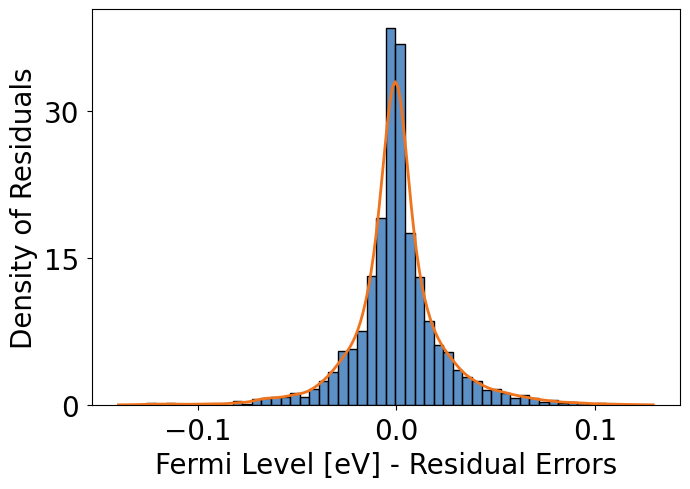

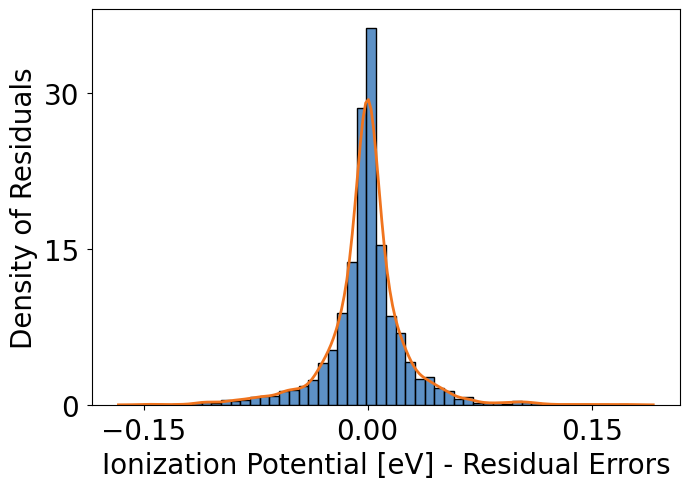

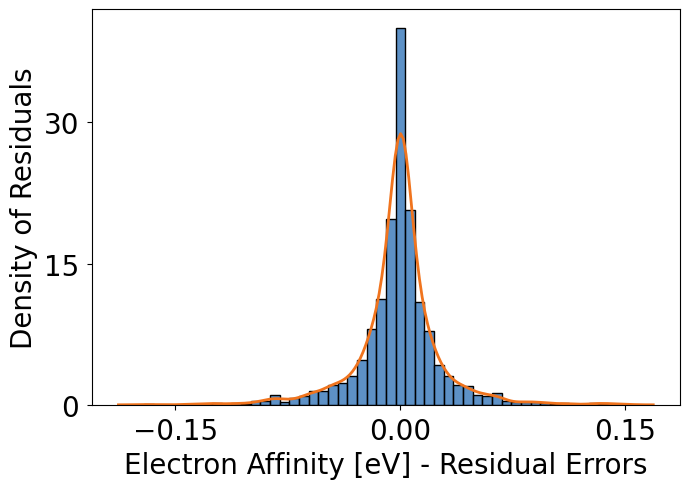

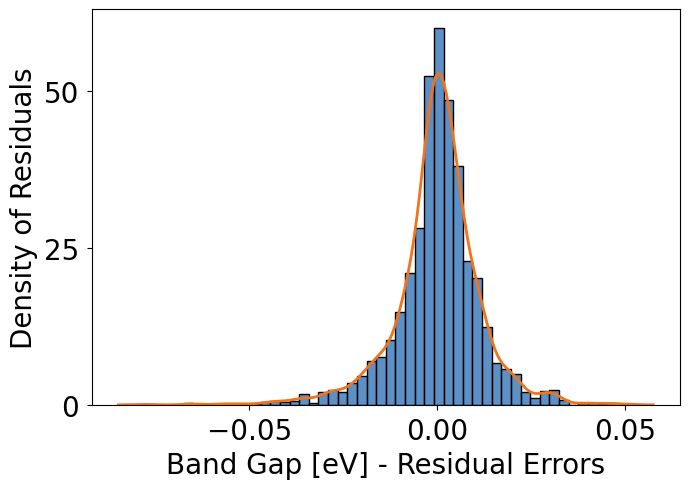

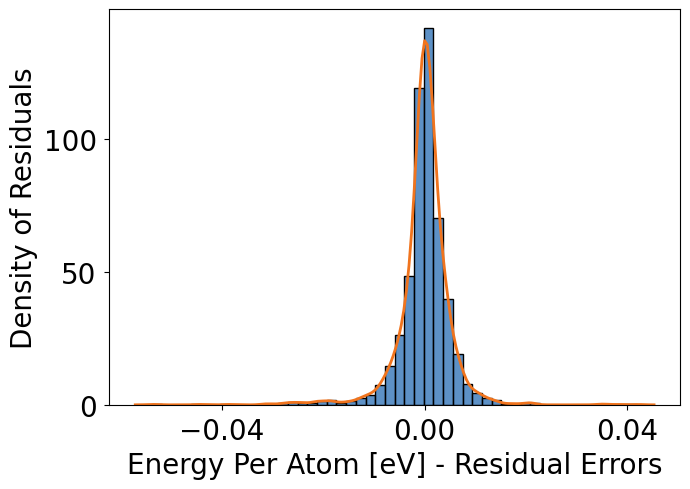

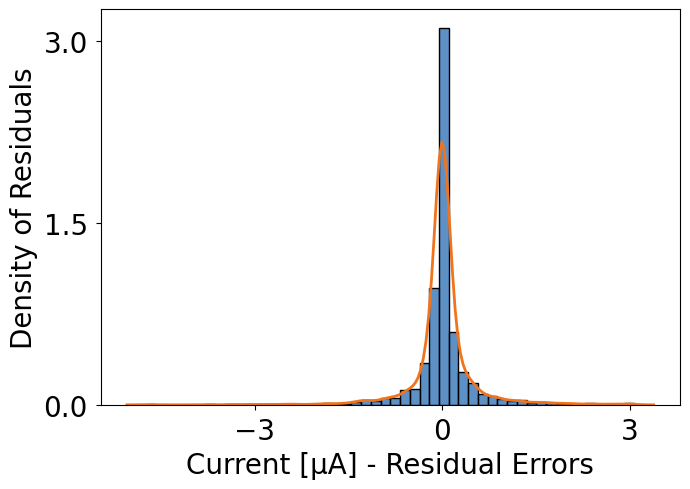

In [6]:
residual_path = plot_path.joinpath("residuals")
residual_path.mkdir(exist_ok=True, parents=True)

residual_target_labels = {
    "fermi_level_ev": ("Fermi Level [eV] - Residual Errors", "Density of Residuals"),
    "EA_ev": ("Electron Affinity [eV] - Residual Errors", "Density of Residuals"),
    "IP_ev": (
        "Ionization Potential [eV] - Residual Errors",
        "Density of Residuals",
    ),
    "band_gap_ev": ("Band Gap [eV] - Residual Errors", "Density of Residuals"),
    "energy_per_atom": (
        "Energy Per Atom [eV] - Residual Errors",
        "Density of Residuals",
    ),
    "current": (
        "Current [μA] - Residual Errors",
        "Density of Residuals",
    ),
    "dos": (
        "DOS - Residual Errors",
        "DOS - Density of Residuals",
    ),
}

target_ticks = {
    "fermi_level_ev" : [-0.1, 0.0,0.1],
    "EA_ev": [-0.15,0.0,0.15],
    "IP_ev": [-0.15,0.0,0.15],
    "band_gap_ev": [-0.05,0.0,0.05],
    "energy_per_atom": [-0.04,0.0, 0.04],
    "current":[-3,0.0, 3],
}
# # Definire il numero di colonne
# num_cols = 2

# # Calcolare il numero di righe necessario in base al numero di target
# num_targets = len(target_list)
# num_rows = (num_targets + num_cols - 1) // num_cols  # Arrotondare verso l'alto

# # Creare i subplots
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6 * num_rows))

# # Iterare sui target e sugli assi
# for idx, target in enumerate(target_list):
#     df = pd.read_csv(pred_path.joinpath(f"{target}_predictions.csv"), header=0)
#     row = idx // num_cols
#     col = idx % num_cols

#     ax = axs[row, col] if num_rows > 1 else axs[col]

#     sns.histplot(
#         x=df[f"{target}_residual"],
#         fill=True,
#         linewidth=1,
#         kde=False,
#         stat="density",
#         color=colors[1],  # Imposta il colore della distribuzione
#         ax=ax,
#         bins=int(np.sqrt(len(df[f"{target}_residual"]))),
#         )

#     sns.kdeplot(x=df[f"{target}_residual"], linewidth=2, color=colors[0], ax=ax)

#     ax.xaxis.set_major_locator(MaxNLocator(nbins=3,min_n_ticks=3))  # Imposta massimo 3 ticks sull'asse x
#     ax.yaxis.set_major_locator(MaxNLocator(nbins=3,min_n_ticks=3))  # Imposta massimo 3 ticks sull'asse y
#     ax.set_xlabel(residual_target_labels[target][0], fontsize=16)
#     ax.set_ylabel(residual_target_labels[target][1], fontsize=16)
#     ax.tick_params(axis="both", which="major", labelsize=14)

#     # Aggiungi un titolo con lettere consecutive
#     letter = chr(97 + idx)  # 97 è il codice ASCII per 'a'
#     ax.set_title(f"({letter})", loc='left', fontsize=16, fontweight='bold')

# # Rimuovere eventuali subplot vuoti
# for idx in range(num_targets, num_rows * num_cols):
#     fig.delaxes(axs.flat[idx])

# # Salvare la figura
# plt.tight_layout()
# plt.savefig(residual_path.joinpath("residual_plots.png"), dpi=300)
# plt.show()

for target in target_list:
    fig = plt.figure(figsize=(7, 5))
    df = pd.read_csv(pred_path.joinpath(f"{target}_predictions.csv"), header=0)
        
    df[f"{target}_residual"] = (df[f"{target}_predicted"] - df[f"{target}_real"])
        
    ax = fig.add_subplot(1, 1, 1)  # Aggiungi subplot

    sns.histplot(
        x=df[f"{target}_residual"],
        fill=True,
        linewidth=1,
        kde=False,
        stat="density",
        color=colors[1],
        ax=ax,
        bins=int(np.sqrt(len(df[f"{target}_residual"]))),
    )

    sns.kdeplot(x=df[f"{target}_residual"], linewidth=2, color=colors[0], ax=ax)

    ax.set_xticks(target_ticks[target])
    #ax.xaxis.set_major_locator(MaxNLocator(nbins=3))  # Imposta massimo 3 ticks sull'asse x
    ax.yaxis.set_major_locator(
        MaxNLocator(nbins=3)
    )  # Imposta massimo 3 ticks sull'asse y
    ax.set_xlabel(residual_target_labels[target][0], fontsize=20)
    ax.set_ylabel(residual_target_labels[target][1], fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.tight_layout()
    plt.savefig(
        residual_path.joinpath(f"{target}_residual.png"), dpi=300, bbox_inches="tight"
    )


LightGBM Residuals


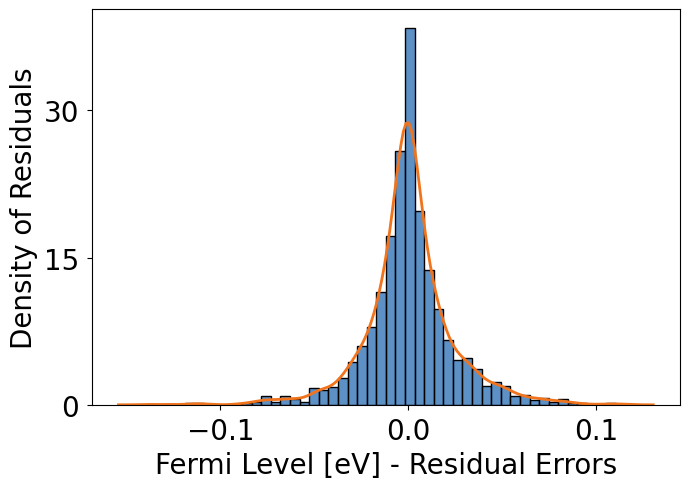

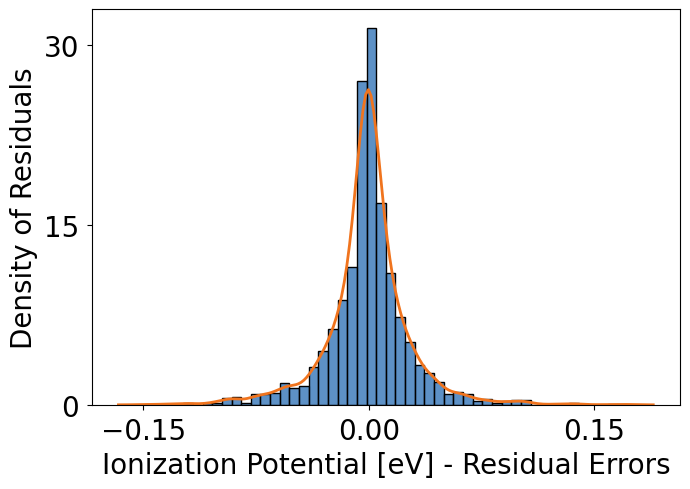

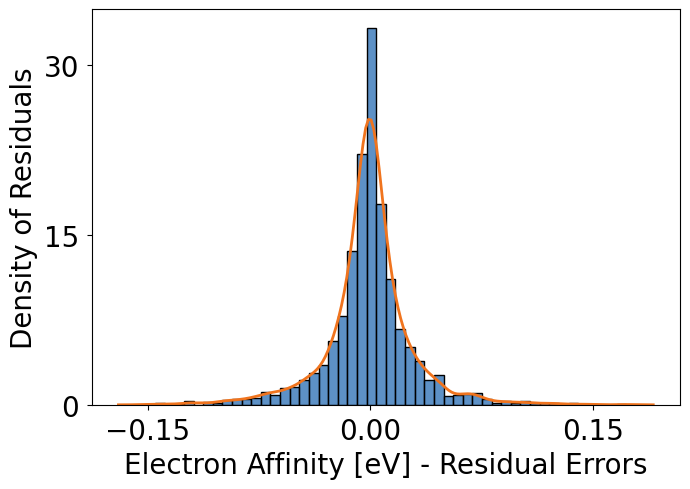

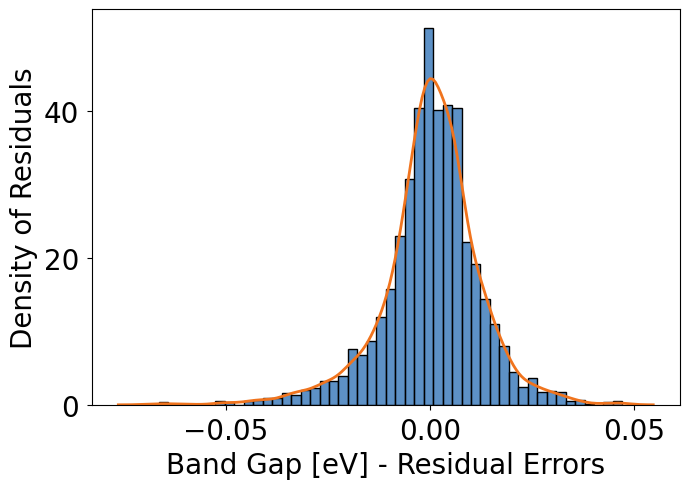

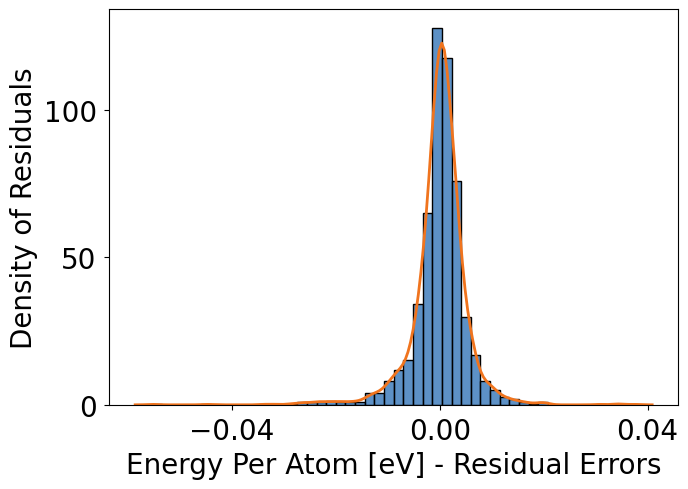

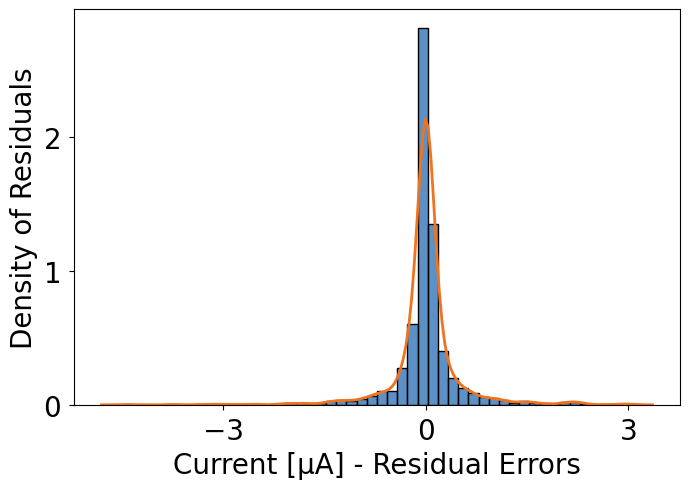

In [8]:
# # Definire il numero di colonne
# num_cols = 2

# # Calcolare il numero di righe necessario in base al numero di target
# num_targets = len(target_list)
# num_rows = (num_targets + num_cols - 1) // num_cols  # Arrotondare verso l'alto

# # Creare i subplots
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6 * num_rows))

# # Iterare sui target e sugli assi
# for idx, target in enumerate(target_list):
#     df = pd.read_csv(pred_path.joinpath(f"{target}_predictions_lightgbm.csv"), header=0)
#     row = idx // num_cols
#     col = idx % num_cols

#     ax = axs[row, col] if num_rows > 1 else axs[col]

#     sns.histplot(
#         x=df[f"{target}_residual"],
#         fill=True,
#         linewidth=1,
#         kde=False,
#         stat="density",
#         color=colors[1],  # Imposta il colore della distribuzione
#         ax=ax,
#         bins=int(np.sqrt(len(df[f"{target}_residual"]))),
#         )

#     sns.kdeplot(x=df[f"{target}_residual"], linewidth=2, color=colors[0], ax=ax)

#     ax.xaxis.set_major_locator(MaxNLocator(nbins=3,min_n_ticks=3))  # Imposta massimo 3 ticks sull'asse x
#     ax.yaxis.set_major_locator(MaxNLocator(nbins=3,min_n_ticks=3))  # Imposta massimo 3 ticks sull'asse y
#     ax.set_xlabel(residual_target_labels[target][0], fontsize=16)
#     ax.set_ylabel(residual_target_labels[target][1], fontsize=16)
#     ax.tick_params(axis="both", which="major", labelsize=14)

#     # Aggiungi un titolo con lettere consecutive
#     letter = chr(97 + idx)  # 97 è il codice ASCII per 'a'
#     ax.set_title(f"({letter})", loc='left', fontsize=16, fontweight='bold')

# # Rimuovere eventuali subplot vuoti
# for idx in range(num_targets, num_rows * num_cols):
#     fig.delaxes(axs.flat[idx])

# # Salvare la figura
# plt.tight_layout()
# plt.savefig(residual_path.joinpath("gbm_residual_plots.png"), dpi=300)
# plt.show()

for target in target_list:
    fig = plt.figure(figsize=(7, 5))
    df = pd.read_csv(pred_path.joinpath(f"{target}_predictions_lightgbm.csv"), header=0)
        
    df[f"{target}_residual"] = (df[f"{target}_predicted"] - df[f"{target}_real"])
        
    ax = fig.add_subplot(1, 1, 1)  # Aggiungi subplot

    sns.histplot(
        x=df[f"{target}_residual"],
        fill=True,
        linewidth=1,
        kde=False,
        stat="density",
        color=colors[1],
        ax=ax,
        bins=int(np.sqrt(len(df[f"{target}_residual"]))),
    )

    sns.kdeplot(x=df[f"{target}_residual"], linewidth=2, color=colors[0], ax=ax)

    ax.set_xticks(target_ticks[target])
    #ax.xaxis.set_major_locator(MaxNLocator(nbins=3))  # Imposta massimo 3 ticks sull'asse x
    ax.yaxis.set_major_locator(
        MaxNLocator(nbins=3)
    )  # Imposta massimo 3 ticks sull'asse y
    ax.set_xlabel(residual_target_labels[target][0], fontsize=20)
    ax.set_ylabel(residual_target_labels[target][1], fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.tight_layout()
    plt.savefig(
        residual_path.joinpath(f"gbm_{target}_residual.png"), dpi=300, bbox_inches="tight"
    )

XGBoost Features Importance


LightGBM Features Importance


In [42]:
importance_path = plot_path.joinpath("importance")
importance_path.mkdir(exist_ok=True, parents=True)

def plot_feature_importances_heatmap(
    feature_importance_dict, features_list, plot_path, model_name
):
    # Normalize importances between 0 and 1 using MinMaxScaler
    all_importances = np.array(list(feature_importance_dict.values()))
    scaler = MinMaxScaler()
    all_importances_normalized = scaler.fit_transform(all_importances.T)

    #targets = list(feature_importance_dict.keys())
    targets = ["Fermi Level - importance","Ionization Potential - importante","Electron Affinity - importance","Band Gap - importance", "Energy per atom - importance", "Current - importance"]

    fig, ax = plt.subplots(figsize=(8, 10))
    sns.heatmap(
        all_importances_normalized,
        annot=True,
        fmt=".4f",
        yticklabels=features_list,
        xticklabels=targets,
        cmap=custom_cmap,#"viridis",
        cbar=False,
        # cbar_kws={'label': 'Normalized Importance', },
        ax=ax,
    )
    # ax.set_xlabel("Targets", fontsize=20)
    # ax.set_ylabel("Features", fontsize=20)
    plt.xticks(rotation=45, ha="right", fontsize=14)
    plt.yticks(rotation=0, fontsize=14)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)

    plt.tight_layout()
    plt.savefig(
        importance_path.joinpath(f"{model_name}_features_importance_heatmap_all_targets.png"),
        dpi=300,
    )
    plt.show()

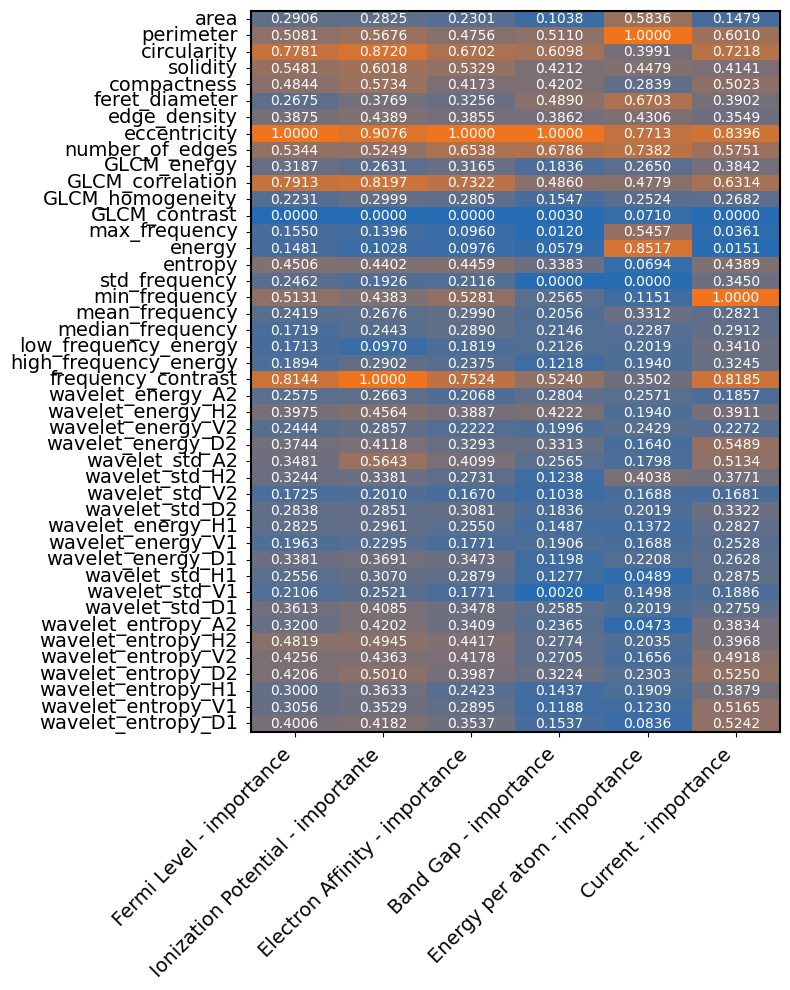

In [43]:
plot_feature_importances_heatmap(
    feature_importance_dict_gbm, features_list, plot_path, model_name="gbm"
)

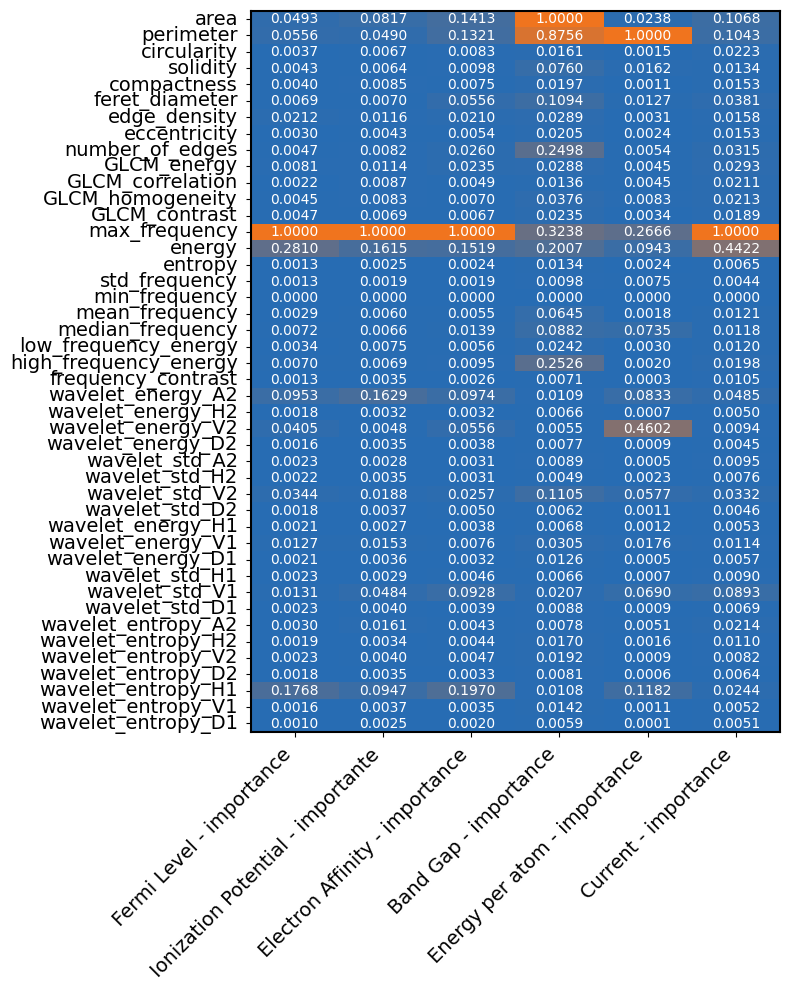

In [44]:
plot_feature_importances_heatmap(
    feature_importance_dict, features_list, plot_path, model_name="xgb"
)

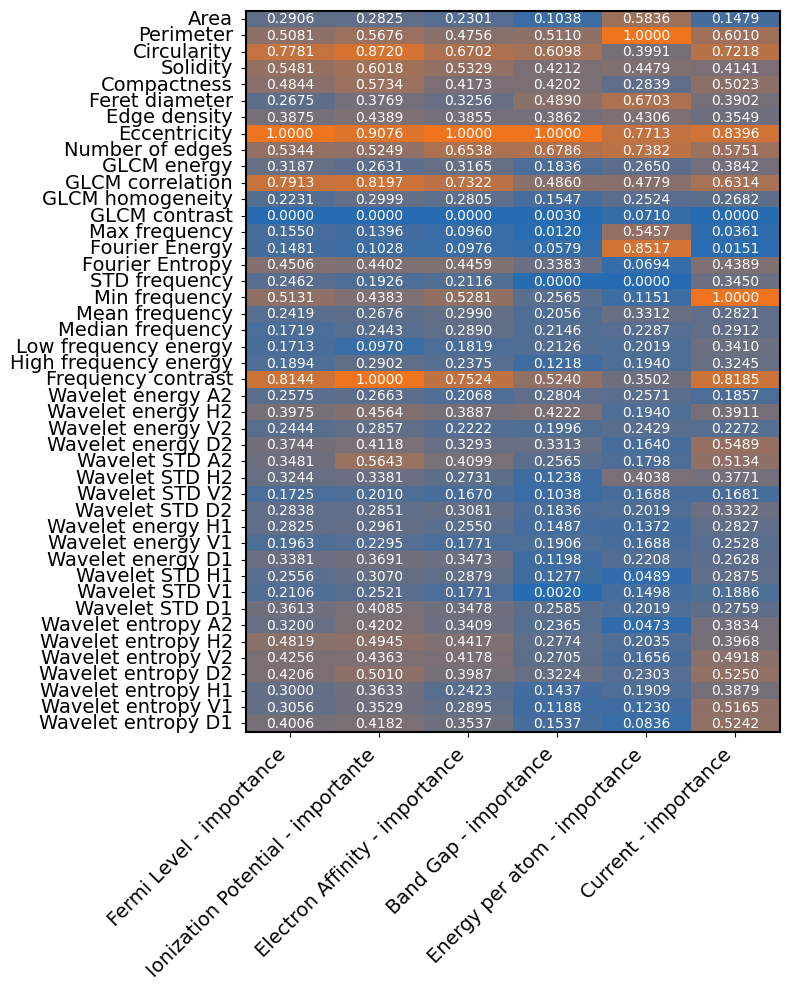

In [45]:
plot_feature_importances_heatmap(
    feature_importance_dict_gbm, features_list_names, plot_path, model_name="gbm"
)

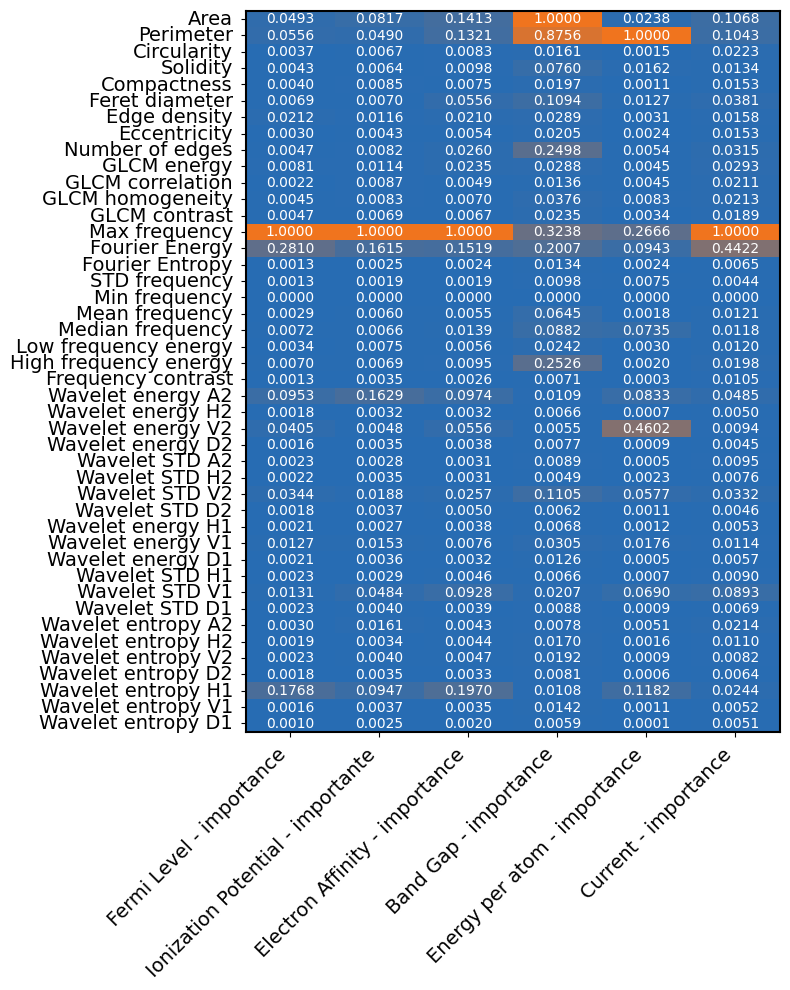

In [46]:
plot_feature_importances_heatmap(
    feature_importance_dict, features_list_names, plot_path, model_name="xgb"
)

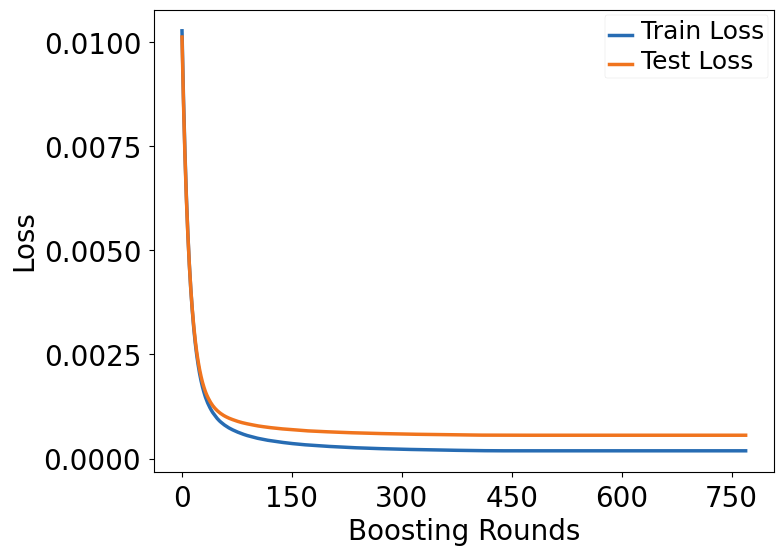

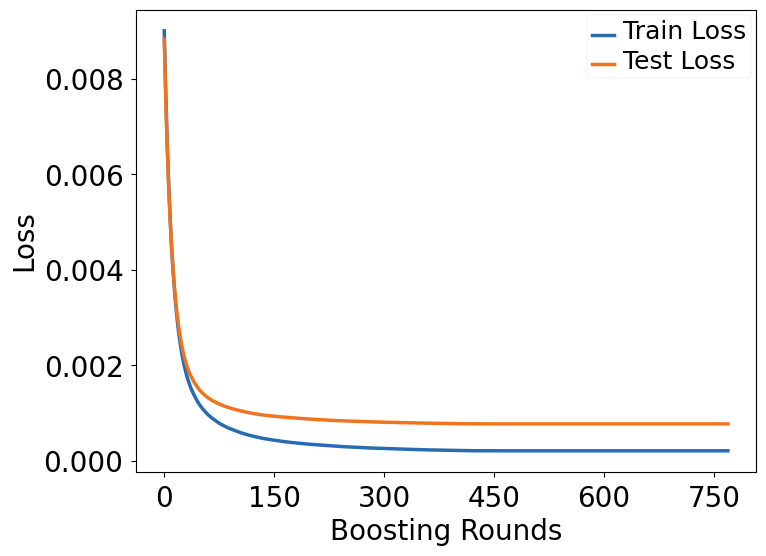

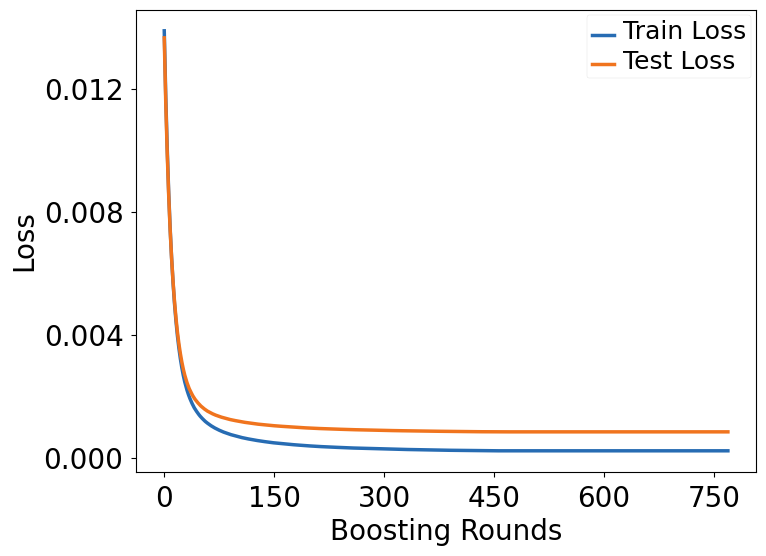

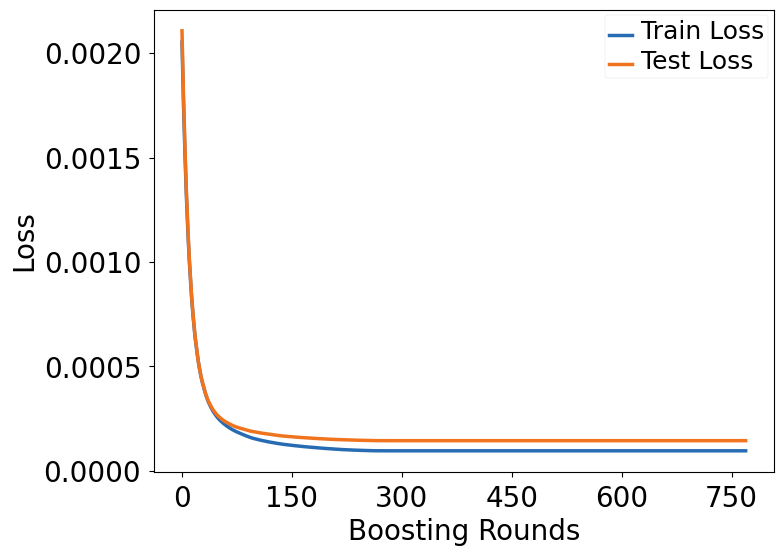

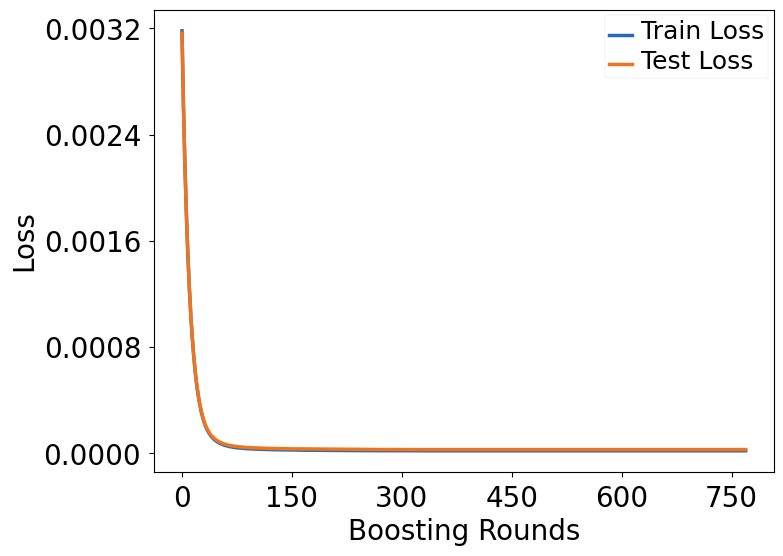

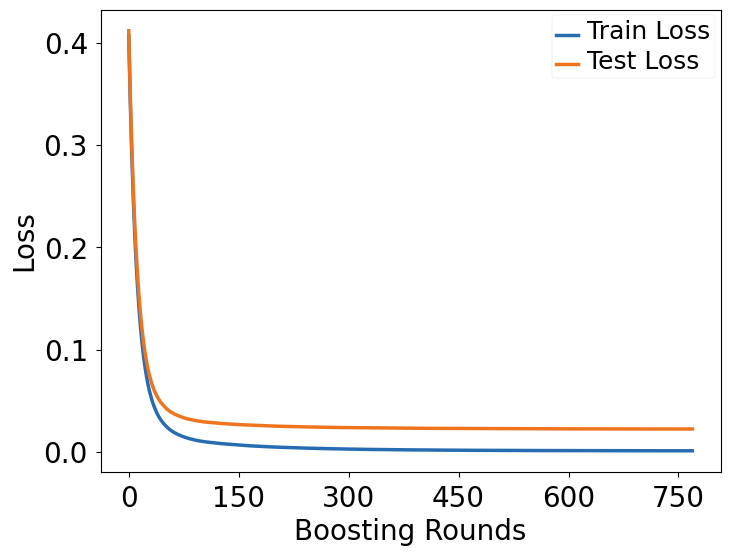

In [47]:
learn_path = plot_path.joinpath("learning_curves")
learn_path.mkdir(exist_ok=True, parents=True)

for target in target_list:
    learning_curve_df = pd.read_csv(pred_path.joinpath(f"gbm_{target}_learning_curve.csv"))
    
    fig = plt.figure(figsize=(8,6))
    sns.lineplot(data=learning_curve_df["train_rmse"], label=f"Train Loss", color=colors[1], linewidth=2.5)
    sns.lineplot(data=learning_curve_df["test_rmse"], label=f"Test Loss", color=colors[0],linewidth=2.5)

    # Configura il locator
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    legend = plt.legend()
    for text in legend.get_texts():
            text.set_fontsize(18) 
    # Aggiungi etichette e titolo
    plt.xlabel("Boosting Rounds", fontsize=20)
    plt.ylabel("Loss", fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.savefig(str(learn_path.joinpath(f"gbm_{target}_learning_curve_rmse.png")), dpi=300, bbox_inches="tight")

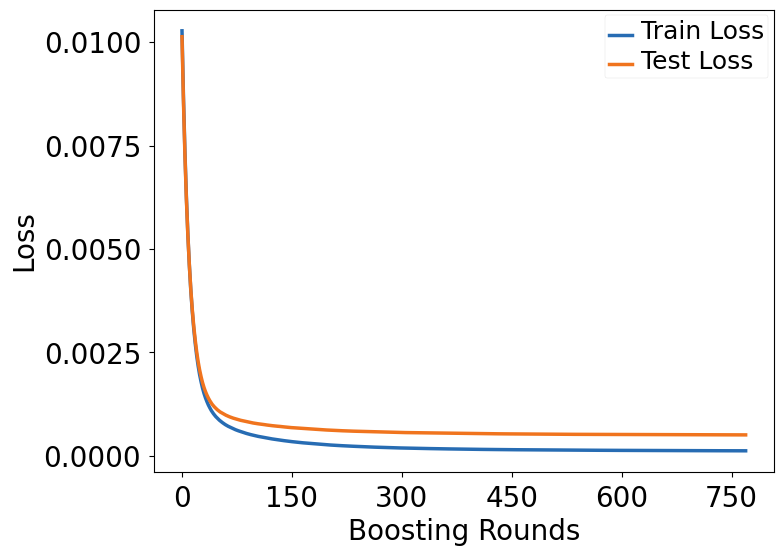

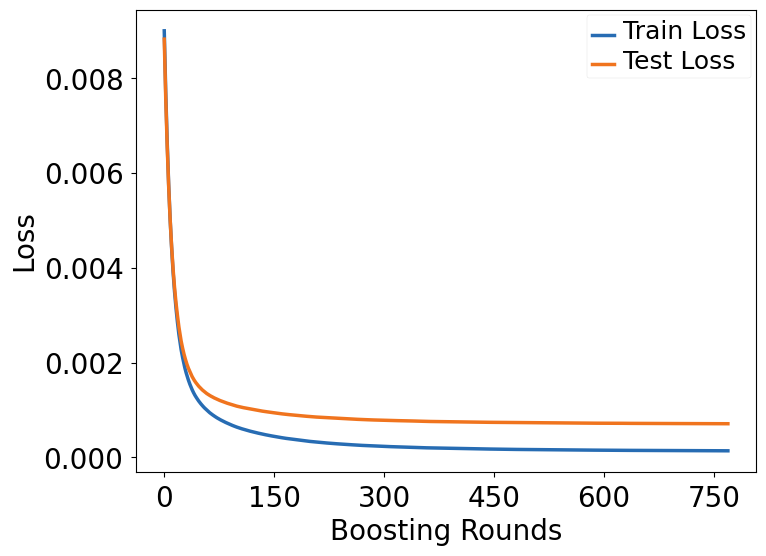

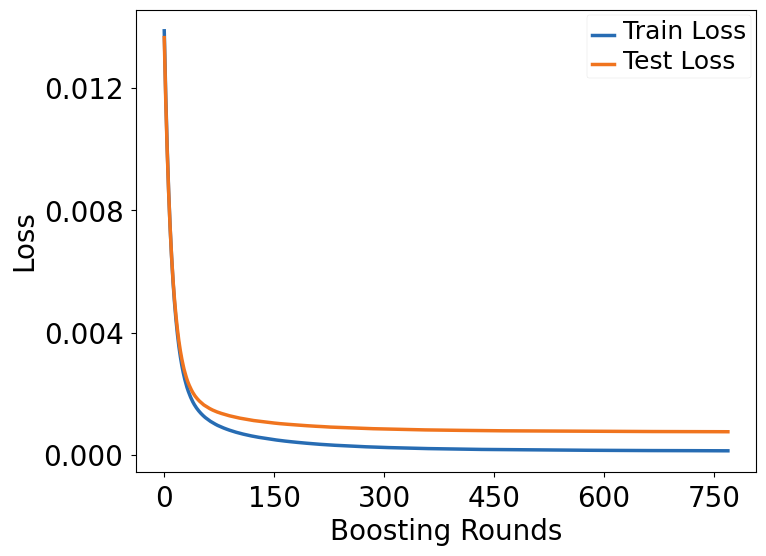

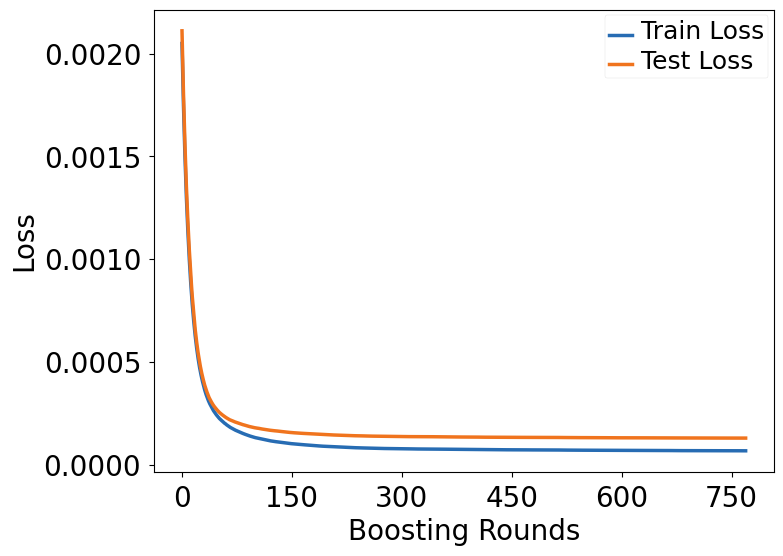

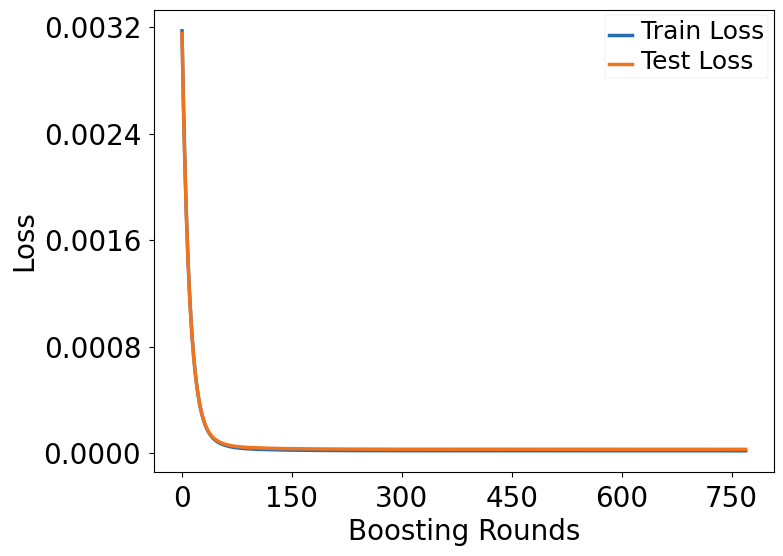

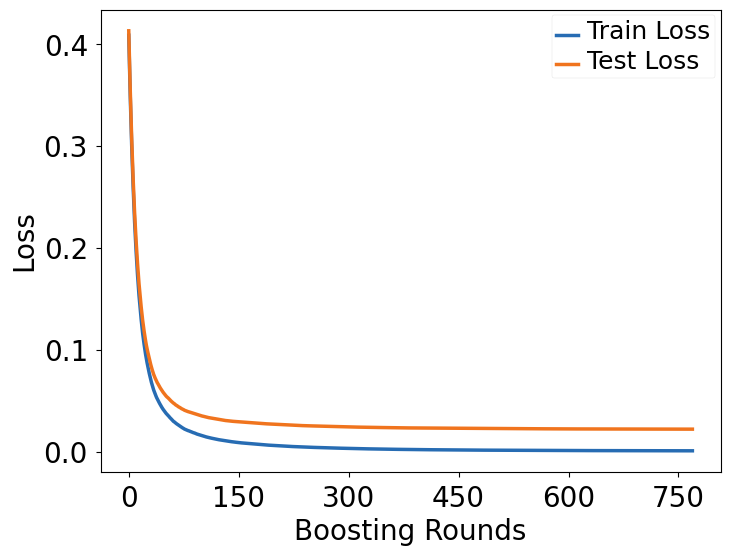

In [48]:
learn_path = plot_path.joinpath("learning_curves")
learn_path.mkdir(exist_ok=True, parents=True)

for target in target_list:
    learning_curve_df = pd.read_csv(pred_path.joinpath(f"{target}_learning_curve.csv"))
    
    fig = plt.figure(figsize=(8,6))
    sns.lineplot(data=learning_curve_df["train_rmse"], label=f"Train Loss", color=colors[1], linewidth=2.5)
    sns.lineplot(data=learning_curve_df["test_rmse"], label=f"Test Loss", color=colors[0],linewidth=2.5)

    # Configura il locator
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    legend = plt.legend()
    for text in legend.get_texts():
            text.set_fontsize(18) 
    # Aggiungi etichette e titolo
    plt.xlabel("Boosting Rounds", fontsize=20)
    plt.ylabel("Loss", fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.savefig(str(learn_path.joinpath(f"{target}_learning_curve_rmse.png")), dpi=300, bbox_inches="tight")

In [50]:
# test riapertura importance

prova_importance_dict = np.load(str(importance_path.joinpath("xgb_importance.npz")))

print(prova_importance_dict)

print(dict(prova_importance_dict))

NpzFile '/home/tom/git_workspace/tesi/GrapheNetDefectDetector/data_tesi_new/plots/importance/xgb_importance.npz' with keys: fermi_level_ev_importance, IP_ev_importance, EA_ev_importance, band_gap_ev_importance, energy_per_atom_importance...
{'fermi_level_ev_importance': array([   0.026101,    0.029375,   0.0025504,   0.0028837,   0.0027099,   0.0042368,    0.011582,   0.0022182,   0.0030782,   0.0048312,   0.0017686,   0.0029731,   0.0030624,     0.51727,     0.14583,   0.0012977,   0.0013315,   0.0006478,   0.0021379,   0.0043769,   0.0024216,    0.004253,   0.0013036,    0.049873,
          0.001564,    0.021589,   0.0014668,   0.0018427,   0.0017923,    0.018409,   0.0015603,   0.0017457,   0.0072327,   0.0017154,   0.0018469,   0.0074187,   0.0018414,   0.0021991,   0.0016459,   0.0018424,   0.0015721,     0.09197,   0.0014842,   0.0011472], dtype=float32), 'IP_ev_importance': array([   0.043747,    0.026697,   0.0045904,   0.0044137,   0.0055127,   0.0047055,   0.0071588,   0.0033